<a href="https://colab.research.google.com/github/jasonericr/dissertation/blob/main/dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### INSTALL/LOAD NECESSARY LIBRARIES

In [ ]:
# for working with Excel files
!pip install openpyxl

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.3 MB/s eta 0:00:00


In [ ]:
!pip install shap

In [ ]:
# Trend analysis
!pip install pymannkendall

In [ ]:
!pip install ruptures
import ruptures as rpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:00


In [ ]:
# import needed libraries
# for data ingestion and prep
from google.colab import files
import io
import json
import os
from openpyxl import load_workbook
from datetime import date as dt
from itertools import product
import re

# for data analysis
import numpy as np
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import missingno as msno
from textwrap import shorten

# for statistical testing
from statsmodels.tsa.stattools import acf
from scipy.stats import ttest_ind  # t-test for changepoint significance
from scipy.stats import norm
import ruptures as rpt # for changepoint detection
import pymannkendall as mk # for trend hypothesis testing


# for ML XGBoost modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             explained_variance_score, mean_absolute_percentage_error,
                             median_absolute_error, make_scorer)

import xgboost as xgb
import shap


#Update pandas display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

##### Package Versions

In [ ]:
!python --version

Python 3.12.12


#### DATA INGESTION

In [ ]:
# financial statement data files to upload
# upload stocks for dissertation folder
uploaded = files.upload()

Saving aal-financials (1).xlsx to aal-financials (1).xlsx
Saving aapl-financials (1).xlsx to aapl-financials (1).xlsx
Saving abt-financials (1).xlsx to abt-financials (1).xlsx
Saving adbe-financials (1).xlsx to adbe-financials (1).xlsx
Saving adm-financials (1).xlsx to adm-financials (1).xlsx
Saving aee-financials (1).xlsx to aee-financials (1).xlsx
Saving aep-financials (1).xlsx to aep-financials (1).xlsx
Saving ait-financials (1).xlsx to ait-financials (1).xlsx
Saving al-financials (1).xlsx to al-financials (1).xlsx
Saving amat-financials (1).xlsx to amat-financials (1).xlsx
Saving amd-financials (1).xlsx to amd-financials (1).xlsx
Saving amgn-financials (1).xlsx to amgn-financials (1).xlsx
Saving amp-financials (1).xlsx to amp-financials (1).xlsx
Saving amt-financials (1).xlsx to amt-financials (1).xlsx
Saving amzn-financials (1).xlsx to amzn-financials (1).xlsx
Saving apd-financials (1).xlsx to apd-financials (1).xlsx
Saving as-financials (1).xlsx to as-financials (1).xlsx
Saving a

In [ ]:
# create an empty dataframe
df = pd.DataFrame()

# loop through all fin statement excel files and load to df
for file in uploaded.keys():
  # create temp df to load each individual stock
  temp_df = pd.DataFrame()

  try:
    # upload file from google docs and transpose; upload by each FS type
    xlsx_file = io.BytesIO(uploaded.get(file))
    income_stmt = pd.read_excel(xlsx_file, 'Income-Quarterly', header=None)
    income_stmt_t = income_stmt.set_index([0]).T.reset_index()
    # need EPS diluted from TTM to calc share price; rename Quarterly EPS Diluted to avoid naming conflict
    income_stmt_t.rename(columns={'EPS (Diluted)': 'EPS (Diluted) Qrtly'}, inplace=True)

    # only pull in TTM EPS diluted to calc share price
    income_stmt_ttm = pd.read_excel(xlsx_file, 'Income-TTM',  header=None)
    income_stmt_ttm_t = income_stmt_ttm.set_index([0]).T.reset_index()
    income_stmt_ttm_t = income_stmt_ttm_t[['index', 'EPS (Diluted)']]
    income_stmt_ttm_t.rename(columns={'index':'index_v'}, inplace=True)

    bs_stmt = pd.read_excel(xlsx_file, 'Balance-Sheet-Quarterly', header=None)
    bs_stmt_t = bs_stmt.set_index([0]).T.reset_index()
    bs_stmt_t.rename(columns={'index':'index_x', 'Date':'date_x'}, inplace=True)

    cf_stmt = pd.read_excel(xlsx_file, 'Cash-Flow-Quarterly', header=None)
    cf_stmt_t = cf_stmt.set_index([0]).T.reset_index()
    cf_stmt_t.rename(columns={'index':'index_y', 'Date':'date_y'}, inplace=True)

    ratios_stmt = pd.read_excel(xlsx_file, 'Ratios-Quarterly', header=None)
    ratios_stmt_t = ratios_stmt.set_index([0]).T.reset_index()
    ratios_stmt_t.rename(columns={'index':'index_z', 'Date':'date_z'}, inplace=True)


    # concatenate all 4 different fin statements into temp df and add field for ticker symbol
    temp_df = pd.concat([income_stmt_t, income_stmt_ttm_t, bs_stmt_t, cf_stmt_t, ratios_stmt_t], axis=1)
    temp_df = temp_df.drop(columns=['index_v', 'index_x', 'index_y', 'index_z', 'date_x', 'date_y', 'date_z'])
    temp_df['ticker_symbol'] = file.replace('-financials (1).xlsx', '')


    if df.empty:
      df = temp_df
    else:
      df = pd.concat([df, temp_df], axis=0)

  except:
    continue

#### DATA CLEANUP

In [ ]:
# change object features to numerical; exclude report date and ticker symbol
obj_cls_list = list(df.select_dtypes('object').columns)[1:-1]
#for col in obj_cls_list:
#  df[col] = np.where(df[col]==None, np.nan, df[col])
for col in obj_cls_list:
  df[col] = df[col].astype('float')

In [ ]:
# Create a copy of dataframe containing all stocks w/ their financials
df_copy = df.copy()

# print # of records before changes
display(print(f'# of records before clean-up: {df_copy.shape[0]}.'))

# calculate stock price at each time interval from Book Value Per Share and Price-to-Book Ratio
df_copy['share_price'] = df_copy['Book Value Per Share'] * df_copy['PB Ratio']
df_copy['share_price'] = df_copy['share_price'].apply(lambda x: np.round(x, 2))

# remove records where there is no share price; allows for the period-over-period stock price change since this is our output
df_no_null_stock_price = df_copy[~df_copy['share_price'].isnull()]
# Group by stock symbol and remove rows with no share price
df_no_null_stock_price = df_no_null_stock_price[df_no_null_stock_price['share_price']!=0]

# number of records before and after removing dataframes with null price values
display(print(f'% of records removed as they have null share prices: {(df_copy.shape[0]-df_no_null_stock_price.shape[0])/df_copy.shape[0]*100:0.1f}%'))

# Calculate price percentage change
# Sort by ticker symbol and date (in ascending order) so most recent dates for each stock are at bottom of dataframe and % change calc can be performed
df_no_null_stock_price = df_no_null_stock_price.sort_values(['ticker_symbol', 'Date'], ascending=[True, True])

# change Data to date data type
df_no_null_stock_price['Date'] = pd.to_datetime(df_no_null_stock_price['Date'])
# limit stocks to those with financial data betwee 1996 and 2024
df_no_null_stock_price = df_no_null_stock_price[(df_no_null_stock_price['Date']>'1995-12-31') & (df_no_null_stock_price['Date']<'2025-01-01')]

# calculate stock price % change period over period for each ticker symbol
df_no_null_stock_price['share_prct_chg'] = df_no_null_stock_price.groupby(['ticker_symbol'], as_index=False)['share_price'].pct_change()
# remove any records with no stock share % change; these would be the earliest records for each stock since they have nothing to comp over
df_no_null_stock_chng = df_no_null_stock_price[~df_no_null_stock_price['share_prct_chg'].isnull()]

# reset index for each stock ticker based on reporting date
# drop original index field
df_no_null_stock_chng = df_no_null_stock_chng.drop(columns=['index'])

# sort df by ticker symbol and date
# reset index based on reporting date grouped by ticker symbol;
# adds an time-series index for each stock so the most recent period starts
# at 1 and each subsequent period gets incremented by 1.  Since stocks have varying history and reporting peiods, this helps with period alignment across
# all stock tickers.
df_no_null_stock_chng = (df_no_null_stock_chng.sort_values(['ticker_symbol', 'Date'],
                                                            ascending=[True, False]))

df_no_null_stock_chng['index'] = df_no_null_stock_chng.groupby(['ticker_symbol'], as_index=False).cumcount()+1

# remove OM stock
df_no_null_stock_chng = df_no_null_stock_chng[df_no_null_stock_chng['ticker_symbol']!='om']

# calc % record loss after
display(print(f'% record loss after dropping stocks with null % change in share price: {(df_no_null_stock_price.shape[0]-df_no_null_stock_chng.shape[0])/df_no_null_stock_price.shape[0]*100:0.1f}%'))
display(print(f'# of records after clean-up: {df_no_null_stock_chng.shape[0]}.'))
df_no_null_stock_chng.head(10)

# of records before clean-up: 21421.


None

% of records removed as they have null share prices: 5.0%


None

% record loss after dropping stocks with null % change in share price: 1.0%


None

# of records after clean-up: 18847.


None

0        Date  Revenue  Revenue Growth  Cost of Revenue  Gross Profit  \
3  2024-12-31  13660.0         0.04578           5868.0        7792.0   
4  2024-09-30  13647.0         0.01224           6291.0        7356.0   
5  2024-06-30  14334.0         0.01985           6427.0        7907.0   
6  2024-03-31  12570.0         0.03126           6212.0        6358.0   
7  2023-12-31  13062.0        -0.00955           6267.0        6795.0   
8  2023-09-30  13482.0         0.00149           6334.0        7148.0   
9  2023-06-30  14055.0         0.04716           5790.0        8265.0   
10 2023-03-31  12189.0         0.36970           6073.0        6116.0   
11 2022-12-31  13188.0         0.39896           6243.0        6945.0   
12 2022-09-30  13462.0         0.50095           6763.0        6699.0   

0   Selling, General & Admin  Research & Development  Operating Expenses  \
3                     4585.0                     0.0              6658.0   
4                     4566.0                     0.0              7267.0   
5                     4409.0                     0.0              6523.0   
6                     4275.0                     0.0              6351.0   
7                     4131.0                     0.0              6139.0   
8                     4404.0                     0.0              7371.0   
9                     4124.0                     0.0              6102.0   
10                    3719.0                     0.0              5678.0   
11                    3683.0                     0.0              5563.0   
12                    3879.0                     0.0              5769.0   

0   Other Operating Expenses  Operating Income  Interest Expense / Income  \
3                     2073.0            1134.0                      470.0   
4                     2701.0              89.0                      480.0   
5                     2114.0            1384.0                      486.0   
6                     2076.0               7.0                      497.0   
7                     2008.0             656.0                      519.0   
8                     2967.0            -223.0                      537.0   
9                     1978.0            2163.0                      548.0   
10                    1959.0             438.0                      540.0   
11                    1880.0            1382.0                      532.0   
12                    1890.0             930.0                      499.0   

0   Other Expense / Income  Pretax Income  Income Tax  Net Income  \
3                   -131.0          795.0       205.0       590.0   
4                   -135.0         -256.0      -107.0      -149.0   
5                   -130.0         1028.0       311.0       717.0   
6                    -77.0         -413.0      -101.0      -312.0   
7                    105.0           32.0        13.0        19.0   
8                    -70.0         -690.0      -145.0      -545.0   
9                   -148.0         1763.0       425.0      1338.0   
10                  -119.0           17.0         7.0        10.0   
11                  -160.0         1010.0       207.0       803.0   
12                  -227.0          658.0       175.0       483.0   

0   Preferred Dividends  Net Income Common  Net Income Growth  \
3                   0.0              590.0           30.05263   
4                   0.0             -149.0                NaN   
5                   0.0              717.0           -0.46413   
6                   0.0             -312.0                NaN   
7                   0.0               19.0           -0.97634   
8                   0.0             -545.0                NaN   
9                   0.0             1338.0            1.81092   
10                  0.0               10.0                NaN   
11                  0.0              803.0                NaN   
12                  0.0              483.0            1.85799   

0   Shares Outstanding (Basic)  Sha

In [ ]:
df_no_null_stock_chng.ticker_symbol.unique()

array(['aal', 'aapl', 'abt', 'adbe', 'adm', 'aee', 'aep', 'ait', 'al',
       'amat', 'amd', 'amgn', 'amp', 'amt', 'amzn', 'apd', 'as', 'ash',
       'axp', 'ba', 'bac', 'bco', 'bdx', 'bk', 'bkng', 'bmy', 'br', 'bsx',
       'bud', 'c', 'car', 'cat', 'cb', 'cbre', 'cci', 'cck', 'cg', 'chtr',
       'ci', 'cl', 'clx', 'cmcsa', 'cmi', 'cop', 'cost', 'cpb', 'cr',
       'csco', 'cvs', 'cvx', 'd', 'dd', 'de', 'dell', 'dg', 'dis', 'dov',
       'dow', 'duk', 'dxc', 'ecl', 'eco', 'ed', 'eix', 'emr', 'eog',
       'eqix', 'etr', 'ets', 'exc', 'f', 'fcn', 'fcx', 'fdx', 'fe', 'fl',
       'fmc', 'foxa', 'g', 'ge', 'gild', 'gis', 'glw', 'googl', 'gs',
       'hal', 'hd', 'hes', 'hi', 'hon', 'hp', 'ibm', 'iff', 'intc', 'ir',
       'itt', 'itw', 'jnj', 'jpm', 'k', 'kmb', 'ko', 'kr', 'l', 'lb',
       'lly', 'lmt', 'low', 'luv', 'm', 'ma', 'mas', 'mat', 'mcd', 'md',
       'mdlz', 'meta', 'mmc', 'mmm', 'mnr', 'mpx', 'mrk', 'ms', 'msft',
       'msi', 'nc', 'nee', 'nem', 'nflx', 'nke', 'nue', 'nvda

In [ ]:
all_tickers = df_no_null_stock_chng[['ticker_symbol','index']]
all_tickers = all_tickers.drop_duplicates(['ticker_symbol'])
all_tickers.to_csv('/content/drive/MyDrive/data/ticker_symbols.csv', index=False)

#### EDA

In [ ]:
# Ticker symbols and their amount of missing share prices
# no rows should be missing share prices
df_no_null_stock_chng.groupby(['ticker_symbol']).agg(null_vals=('share_price', lambda x:x.isnull().sum()))

null_vals
ticker_symbol           
aal                    0
aapl                   0
abt                    0
adbe                   0
adm                    0
aee                    0
aep                    0
ait                    0
al                     0
amat                   0
amd                    0
amgn                   0
amp                    0
amt                    0
amzn                   0
apd                    0
as                     0
ash                    0
axp                    0
ba                     0
bac                    0
bco                    0
bdx                    0
bk                     0
bkng                   0
bmy                    0
br                     0
bsx                    0
bud                    0
c                      0
car                    0
cat                    0
cb                     0
cbre                   0
cci                    0
cck                    0
cg                     0
chtr                   0
ci                     0
cl                     0
clx                    0
cmcsa                  0
cmi                    0
cop                    0
cost                   0
cpb                    0
cr                     0
csco                   0
cvs                    0
cvx                    0
d                      0
dd                     0
de                     0
dell                   0
dg                     0
dis                    0
dov                    0
dow                    0
duk                    0
dxc                    0
ecl                    0
eco                    0
ed                     0
eix                    0
emr                    0
eog                    0
eqix                   0
etr                    0
ets                    0
exc                    0
f                      0
fcn                    0
fcx                    0
fdx                    0
fe                     0
fl                     0
fmc                    0
foxa                   0
g                      0
ge                     0
gild                   0
gis                    0
glw                    0
googl                  0
gs                     0
hal                    0
hd                     0
hes                    0
hi                     0
hon                    0
hp                     0
ibm                    0
iff                    0
intc                   0
ir                     0
itt                    0
itw                    0
jnj                    0
jpm                    0
k                      0
kmb                    0
ko                     0
kr                     0
l                      0
lb                     0
lly                    0
lmt                    0
low                    0
luv                    0
m                      0
ma                     0
mas                    0
mat                    0
mcd                    0
md                     0
mdlz                   0
meta                   0
mmc                    0
mmm                    0
mnr                    0
mpx                    0
mrk                    0
ms                     0
msft                   0
msi                    0
nc                     0
nee                    0
nem                    0
nflx                   0
nke                    0
nue                    0
nvda                   0
nwl                    0
o                      0
oke                    0
orcl                   0
oxy                    0
pbi                    0
peg                    0
pep                    0
pfe                    0
pg                     0
pld                    0
pll                    0
pnc                    0
psa                    0
psx                    0
qcom                   0
r                      0
rost                   0
s                      0
sbux                   0
shw                    0
snt                    0
so                     0
spg                    0
t                      0
tfsl                   0
tgt            

In [ ]:
# check the maximum reporting date for each stock ticker
# all are within Q4 2024; each stock will report on slightly different timeframes; not all will be Dec 2024
df_no_null_stock_chng.groupby(['ticker_symbol']).agg(max_dates=('Date', np.max))


/tmp/ipython-input-583532194.py:3: FutureWarning: The provided callable <function max at 0x7b8a2bfd2e80> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_no_null_stock_chng.groupby(['ticker_symbol']).agg(max_dates=('Date', np.max))


max_dates
ticker_symbol           
aal           2024-12-31
aapl          2024-12-28
abt           2024-12-31
adbe          2024-11-29
adm           2024-12-31
aee           2024-12-31
aep           2024-12-31
ait           2024-12-31
al            2024-12-31
amat          2024-10-27
amd           2024-12-28
amgn          2024-12-31
amp           2024-12-31
amt           2024-12-31
amzn          2024-12-31
apd           2024-12-31
as            2024-12-31
ash           2024-12-31
axp           2024-12-31
ba            2024-12-31
bac           2024-12-31
bco           2024-12-31
bdx           2024-12-31
bk            2024-12-31
bkng          2024-12-31
bmy           2024-12-31
br            2024-12-31
bsx           2024-12-31
bud           2024-12-31
c             2024-12-31
car           2024-12-31
cat           2024-12-31
cb            2024-12-31
cbre          2024-12-31
cci           2024-12-31
cck           2024-12-31
cg            2024-12-31
chtr          2024-12-31
ci            2024-12-31
cl            2024-12-31
clx           2024-12-31
cmcsa         2024-12-31
cmi           2024-12-31
cop           2024-12-31
cost          2024-11-24
cpb           2024-10-27
cr            2024-12-31
csco          2024-10-26
cvs           2024-12-31
cvx           2024-12-31
d             2024-12-31
dd            2024-12-31
de            2024-10-27
dell          2024-11-01
dg            2024-11-01
dis           2024-12-28
dov           2024-12-31
dow           2024-12-31
duk           2024-12-31
dxc           2024-12-31
ecl           2024-12-31
eco           2024-12-19
ed            2024-12-31
eix           2024-12-31
emr           2024-12-31
eog           2024-12-31
eqix          2024-12-31
etr           2024-12-31
ets           2005-10-01
exc           2024-12-31
f             2024-12-31
fcn           2024-12-31
fcx           2024-12-31
fdx           2024-11-30
fe            2024-12-31
fl            2024-11-02
fmc           2024-12-31
foxa          2024-12-31
g             2024-12-31
ge            2024-12-31
gild          2024-12-31
gis           2024-11-24
glw           2024-12-31
googl         2024-12-31
gs            2024-12-31
hal           2024-12-31
hd            2024-10-27
hes           2024-12-31
hi            2024-12-31
hon           2024-12-31
hp            2024-12-31
ibm           2024-12-31
iff           2024-12-31
intc          2024-12-28
ir            2024-12-31
itt           2024-12-31
itw           2024-12-31
jnj           2024-12-29
jpm           2024-12-31
k             2024-12-28
kmb           2024-12-31
ko            2024-12-31
kr            2024-11-09
l             2024-12-31
lb            2024-12-31
lly           2024-12-31
lmt           2024-12-31
low           2024-11-01
luv           2024-12-31
m             2024-11-02
ma            2024-12-31
mas           2024-12-31
mat           2024-12-31
mcd           2024-12-31
md            2024-12-31
mdlz          2024-12-31
meta          2024-12-31
mmc           2024-12-31
mmm           2024-12-31
mnr           2024-12-31
mpx           2024-12-31
mrk           2024-12-31
ms            2024-12-31
msft          2024-12-31
msi           2024-12-31
nc            2024-12-31
nee           2024-12-31
nem           2024-12-31
nflx          2024-12-31
nke           2024-11-30
nue           2024-12-31
nvda          2024-10-27
nwl           2024-12-31
o             2024-12-31
oke           2024-12-31
orcl          2024-11-30
oxy           2024-12-31
pbi           2024-12-31
peg           2024-12-31
pep           2024-12-28
pfe           2024-12-31
pg            2024-12-31
pld           2024-12-31
pll           2024-12-31
pnc           2024-12-31
psa           2024-12-31
psx           2024-12-31
qcom          2024-12-29
r             2024-12-31
rost          2024-11-02
s             2024-10-31
sbux          2024-12-29
shw           2024-12-31
snt           2023-09-30
so            2024-12-31
spg           2024-12-31
t             2024-12-31
tfsl          2024-12-31
tgt           2

##### Check NULL values for Predictor Features

In [ ]:
# check % missing values by feature
(df_no_null_stock_chng.isnull().sum()/df_no_null_stock_chng.shape[0]*100).sort_values(ascending=False)

0
Return on Assets (ROA)               100.000000
Return on Equity (ROE)               100.000000
Asset Turnover                       100.000000
Net Cash (Debt) Growth                84.708442
Dividend Growth                       38.817849
Free Cash Flow Growth                 35.369024
Net Cash Per Share                    28.413010
Shares Outstanding (Diluted)          28.413010
Other Investing Activities            26.837162
EPS Growth                            21.165172
Other Financing Activities            20.857431
Net Income Growth                     17.100865
Operating Cash Flow Growth            16.633947
Working Capital                       14.861782
Current Ratio                         14.861782
Quick Ratio                           14.856476
Total Current Liabilities             14.856476
Other Current Liabilities             14.856476
Other Long-Term Liabilities           14.856476
Total Long-Term Liabilities           14.856476
Long-Term Debt                        14.840558
Current Debt                          14.782193
Total Long-Term Assets                14.697299
Other Long-Term Assets                14.697299
Other Current Assets                  14.697299
Total Current Assets                  14.697299
Short-TermInvestments                 14.691993
Long-Term Investments                 14.691993
Effective Tax Rate                    11.381122
Other Expense / Income                11.206027
Debt Growth                            4.923861
Retained Earnings                      4.738155
Debt/Equity                            2.965989
EPS (Diluted)                          2.207248
Shares Change                          1.761554
EPS (Diluted) Qrtly                    1.459118
Market Cap Growth                      1.315859
Share-Based Compensation               1.268106
Free Cash Flow Margin                  1.230965
Free Cash Flow Margin                  1.230965
EBITDA Margin                          1.220353
Revenue Growth                         1.199130
Buyback Yield                          1.188518
Cash Growth                            1.140765
Operating Margin                       0.949753
Dividends Paid                         0.843636
Share Issuance / Repurchase            0.822412
Change in Investments                  0.822412
Acquisitions                           0.811800
P/OCF Ratio                            0.806494
P/FCF Ratio                            0.801189
EBITDA                                 0.790577
Debt Issued / Paid                     0.790577
Depreciation & Amortization            0.785271
Depreciation & Amortization            0.785271
Net Cash Flow                          0.774659
Financing Cash Flow                    0.774659
Operating Cash Flow                    0.769353
Free Cash Flow                         0.769353
Free Cash Flow Per Share               0.769353
Capital Expenditures                   0.769353
Free Cash Flow Per Share               0.769353
Investing Cash Flow                    0.769353
Profit Margin                          0.716294
EBIT Margin                            0.716294
Gross Margin                           0.700377
Return on Invested Capital (ROIC)      0.509365
Payout Ratio                           0.498753
Operating Income                       0.482835
Operating Expenses                     0.482835
PE Ratio                               0.461612
Other Operating Activities             0.307741
EPS (Basic)                            0.291824
Cost of Revenue                        0.254682
Gross Profit                           0.254682
Research & Development                 0.254682
Selling, General & Admin               0.254682
Net Income                             0.254682
Revenue                                0.254682
Preferred Dividends                    0.254682
Interest Expense / Income              0.254682
Income Tax                             0.254682
EBIT                                   0.254682
Net Income    

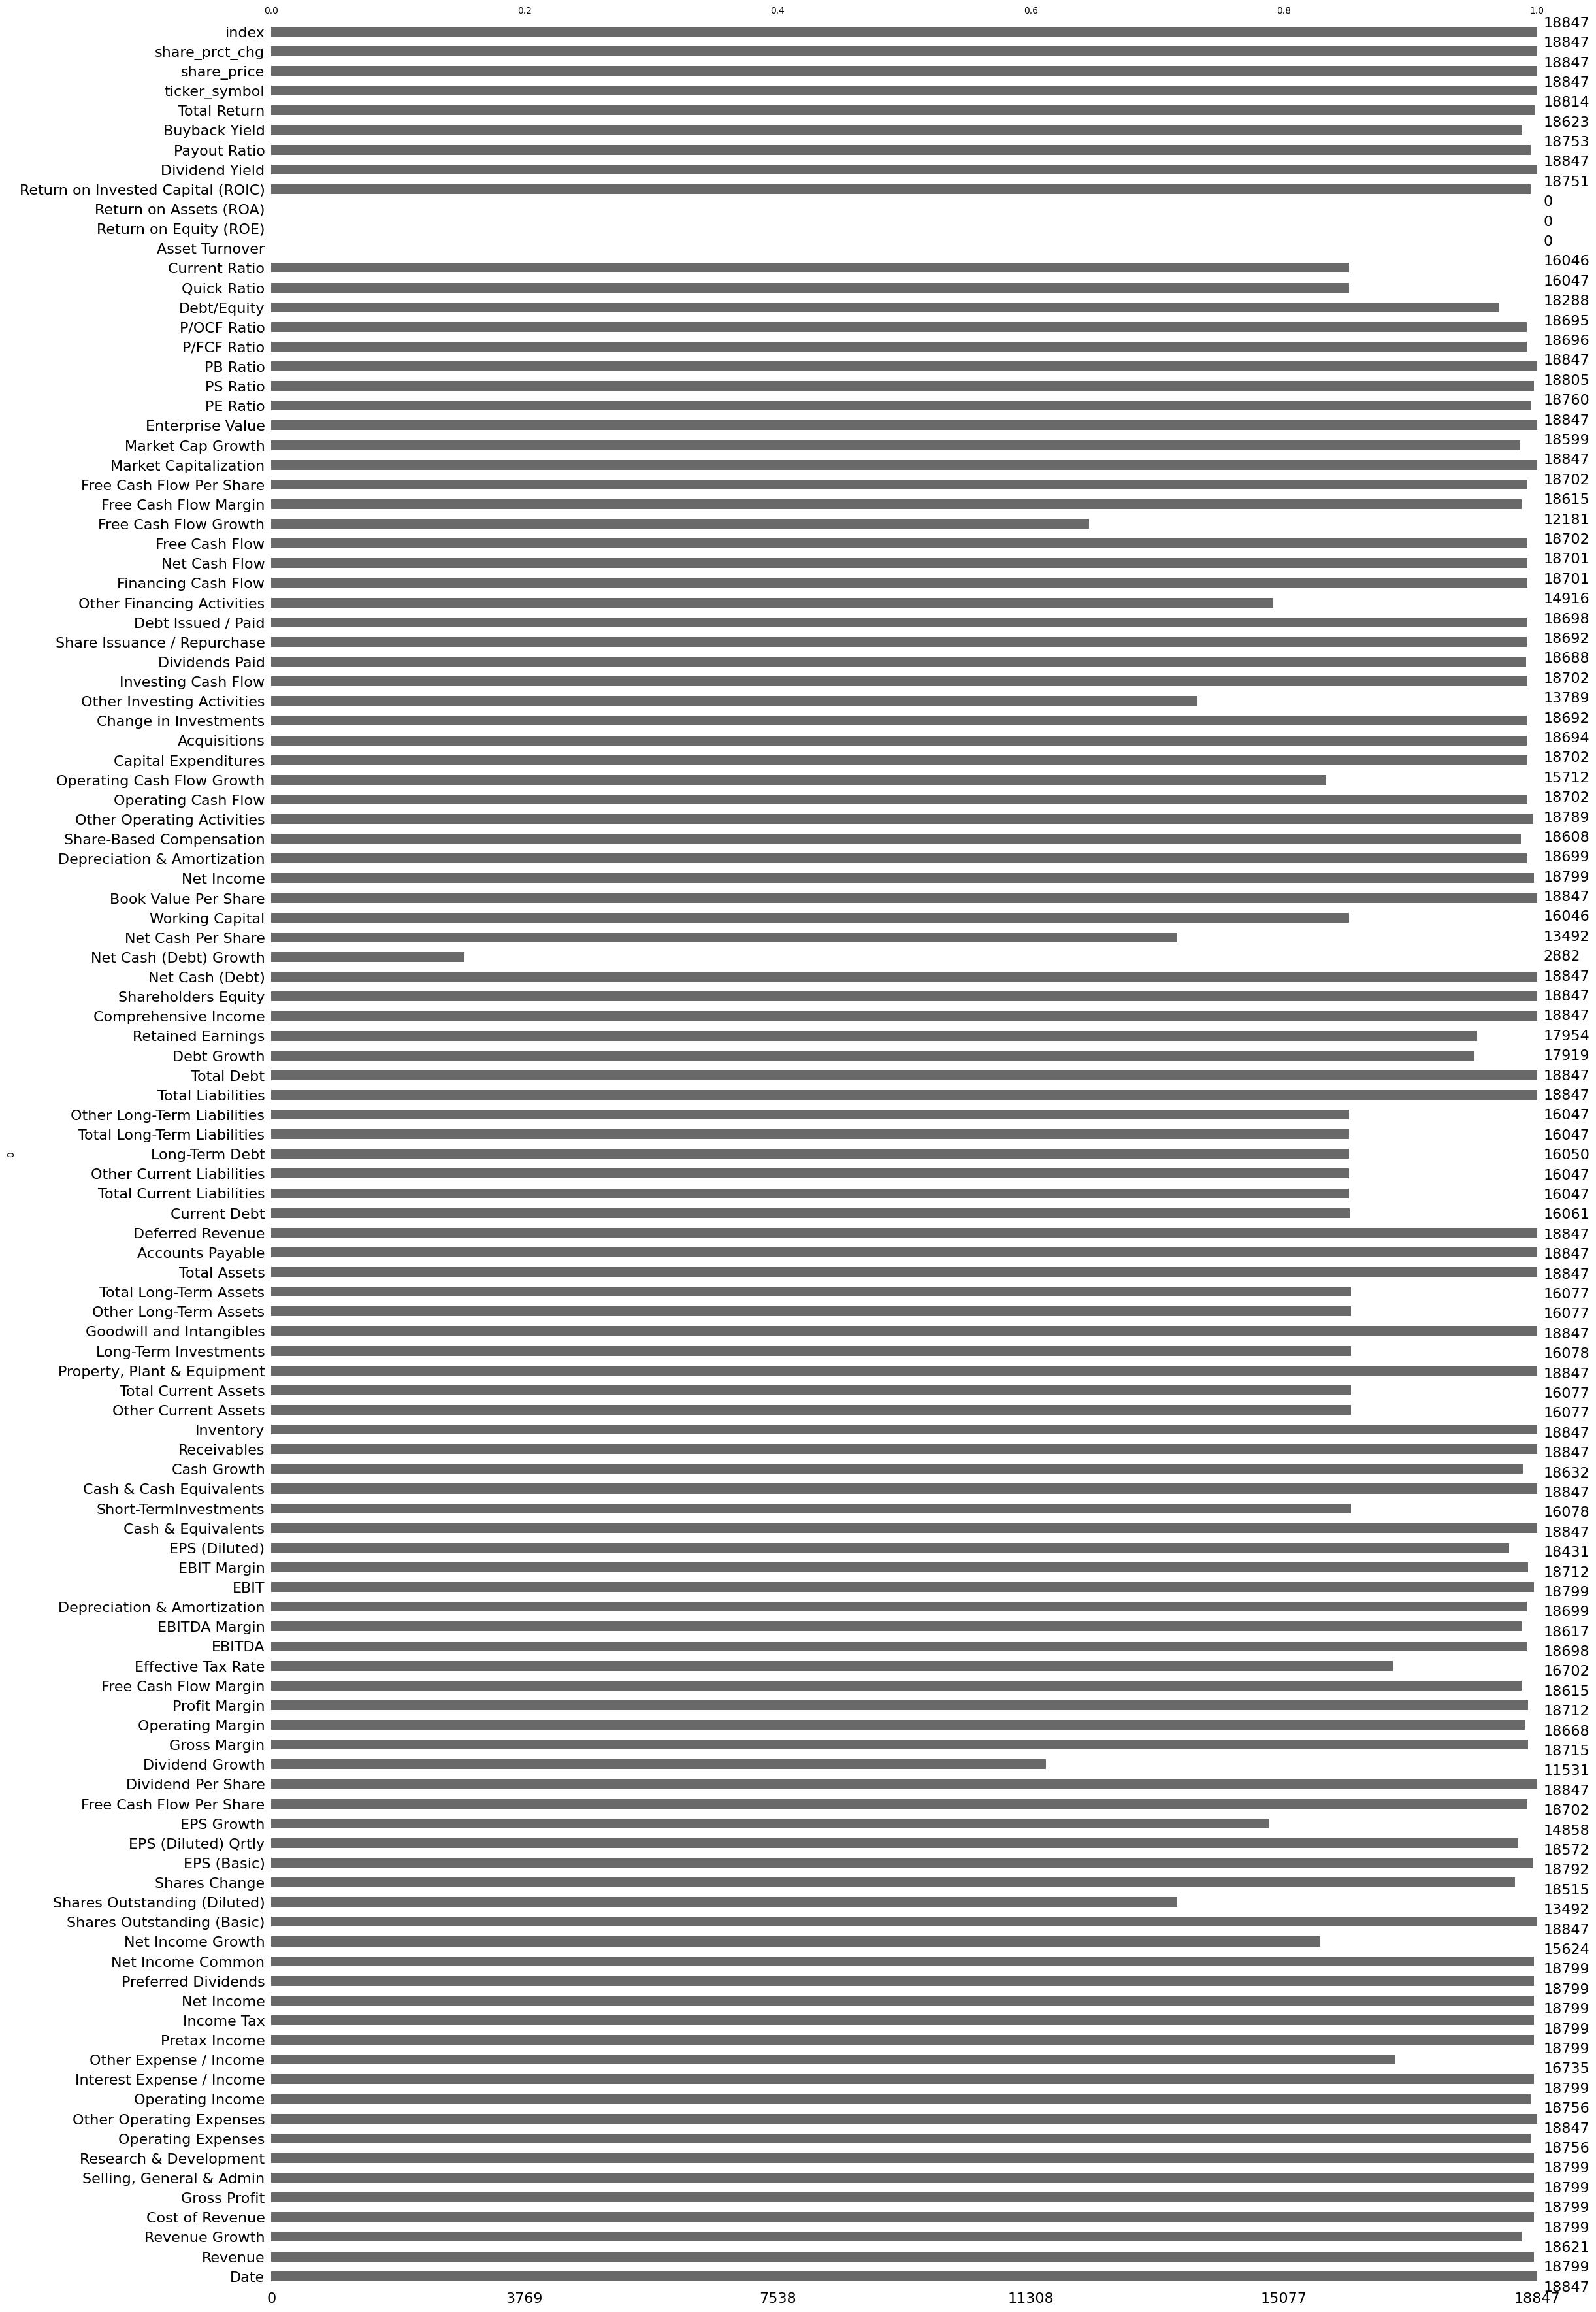

In [ ]:
# Visualize missing values
# missing feature variables values are purposeful as they represent true absences of values
msno.bar(df_no_null_stock_chng)
plt.show()

In [ ]:
# Verify that the share price % change field (target variable) has no NULL values; need all share prices
assert df_no_null_stock_chng[df_no_null_stock_chng['share_prct_chg'].isnull()].shape[0] == 0, 'Not all share prices % changes values are zero. Check the forward-fill.'

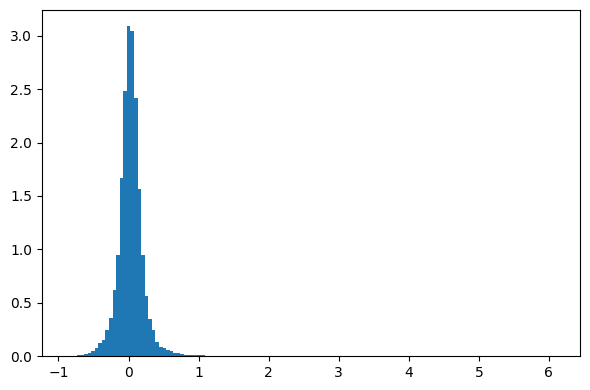

In [ ]:
# Explore distribution of Share Price % Change
plt.figure(figsize=(6,4))
plt.hist(x=df_no_null_stock_chng['share_prct_chg'],
         histtype='stepfilled',
         bins=int(np.sqrt(df_no_null_stock_chng.shape[0])),
         density=True)
plt.tight_layout()
plt.show()

#### ADDITIONAL FEATURE ENGINEERING

In [ ]:

# # remove Date field as no longer needed given Index provides chronological variable
df_no_date = df_no_null_stock_chng.drop(columns=['Date'])

# # Drop columns with no data
no_missing_data_mask = ((df_no_date.isnull().sum()/df_no_date.shape[0]) != 100.00)

# # Remove fields missing all data
df_filtered = df_no_date[list(df_no_date.columns[no_missing_data_mask])]
df_filtered.head()

0  Revenue  Revenue Growth  Cost of Revenue  Gross Profit  \
3  13660.0         0.04578           5868.0        7792.0   
4  13647.0         0.01224           6291.0        7356.0   
5  14334.0         0.01985           6427.0        7907.0   
6  12570.0         0.03126           6212.0        6358.0   
7  13062.0        -0.00955           6267.0        6795.0   

0  Selling, General & Admin  Research & Development  Operating Expenses  \
3                    4585.0                     0.0              6658.0   
4                    4566.0                     0.0              7267.0   
5                    4409.0                     0.0              6523.0   
6                    4275.0                     0.0              6351.0   
7                    4131.0                     0.0              6139.0   

0  Other Operating Expenses  Operating Income  Interest Expense / Income  \
3                    2073.0            1134.0                      470.0   
4                    2701.0              89.0                      480.0   
5                    2114.0            1384.0                      486.0   
6                    2076.0               7.0                      497.0   
7                    2008.0             656.0                      519.0   

0  Other Expense / Income  Pretax Income  Income Tax  Net Income  Net Income  \
3                  -131.0          795.0       205.0       590.0       590.0   
4                  -135.0         -256.0      -107.0      -149.0      -149.0   
5                  -130.0         1028.0       311.0       717.0       717.0   
6                   -77.0         -413.0      -101.0      -312.0      -312.0   
7                   105.0           32.0        13.0        19.0        19.0   

0  Preferred Dividends  Net Income Common  Net Income Growth  \
3                  0.0              590.0           30.05263   
4                  0.0             -149.0                NaN   
5                  0.0              717.0           -0.46413   
6                  0.0             -312.0                NaN   
7                  0.0               19.0           -0.97634   

0  Shares Outstanding (Basic)  Shares Outstanding (Diluted)  Shares Change  \
3                  657.130996                           NaN        0.00549   
4                  656.703913                           NaN        0.00511   
5                  656.090344                           NaN        0.00494   
6                  655.847000                       655.847        0.00678   
7                  653.540550                           NaN        0.00560   

0  EPS (Basic)  EPS (Diluted) Qrtly  EPS Growth  Free Cash Flow Per Share  \
3         0.90                 0.85    16.00000                    -0.435   
4        -0.23                -0.23         NaN                     0.082   
5         1.09                 1.01    -0.46277                     1.265   
6        -0.48                -0.48         NaN                     2.068   
7         0.03                 0.05    -0.95935                    -3.340   

0  Free Cash Flow Per Share  Dividend Per Share  Dividend Growth  \
3                    -0.435                 0.0              NaN   
4                     0.082                 0.0              NaN   
5                     1.265                 0.0              NaN   
6                     2.068                 0.0              NaN   
7                    -3.340                 0.0              NaN   

0  Gross Margin  Operating Margin  Profit Margin  Free Cash Flow Margin  \
3       0.57042           0.08302        0.04319               -0.02094   
4       0.53902           0.00652       -0.01092                0.00396   
5       0.55163           0.09655        0.05002                0.05790   
6       0.50581           0.00056       -0.02482                0.10788   
7       0.52021           0.05022        0.00145               -0.16713   

0  Free Cash Flow Margin  Effective Tax Rate  EBITDA  EBITDA Margin

In [ ]:
# Remove columns that have 100% null values
df_filtered = df_no_date.dropna(axis=1, how='all')

In [ ]:
# Check to see there are no columns missing 100% data
(df_filtered.isnull().sum()/df_filtered.shape[0]*100).sort_values(ascending=False)

0
Net Cash (Debt) Growth               84.708442
Dividend Growth                      38.817849
Free Cash Flow Growth                35.369024
Shares Outstanding (Diluted)         28.413010
Net Cash Per Share                   28.413010
Other Investing Activities           26.837162
EPS Growth                           21.165172
Other Financing Activities           20.857431
Net Income Growth                    17.100865
Operating Cash Flow Growth           16.633947
Current Ratio                        14.861782
Working Capital                      14.861782
Total Long-Term Liabilities          14.856476
Other Long-Term Liabilities          14.856476
Total Current Liabilities            14.856476
Quick Ratio                          14.856476
Other Current Liabilities            14.856476
Long-Term Debt                       14.840558
Current Debt                         14.782193
Other Long-Term Assets               14.697299
Total Current Assets                 14.697299
Other Current Assets                 14.697299
Total Long-Term Assets               14.697299
Short-TermInvestments                14.691993
Long-Term Investments                14.691993
Effective Tax Rate                   11.381122
Other Expense / Income               11.206027
Debt Growth                           4.923861
Retained Earnings                     4.738155
Debt/Equity                           2.965989
EPS (Diluted)                         2.207248
Shares Change                         1.761554
EPS (Diluted) Qrtly                   1.459118
Market Cap Growth                     1.315859
Share-Based Compensation              1.268106
Free Cash Flow Margin                 1.230965
Free Cash Flow Margin                 1.230965
EBITDA Margin                         1.220353
Revenue Growth                        1.199130
Buyback Yield                         1.188518
Cash Growth                           1.140765
Operating Margin                      0.949753
Dividends Paid                        0.843636
Share Issuance / Repurchase           0.822412
Change in Investments                 0.822412
Acquisitions                          0.811800
P/OCF Ratio                           0.806494
P/FCF Ratio                           0.801189
EBITDA                                0.790577
Debt Issued / Paid                    0.790577
Depreciation & Amortization           0.785271
Depreciation & Amortization           0.785271
Financing Cash Flow                   0.774659
Net Cash Flow                         0.774659
Free Cash Flow                        0.769353
Operating Cash Flow                   0.769353
Capital Expenditures                  0.769353
Free Cash Flow Per Share              0.769353
Investing Cash Flow                   0.769353
Free Cash Flow Per Share              0.769353
Profit Margin                         0.716294
EBIT Margin                           0.716294
Gross Margin                          0.700377
Return on Invested Capital (ROIC)     0.509365
Payout Ratio                          0.498753
Operating Expenses                    0.482835
Operating Income                      0.482835
PE Ratio                              0.461612
Other Operating Activities            0.307741
EPS (Basic)                           0.291824
Revenue                               0.254682
Research & Development                0.254682
Gross Profit                          0.254682
Cost of Revenue                       0.254682
Pretax Income                         0.254682
Net Income                            0.254682
Income Tax                            0.254682
Preferred Dividends                   0.254682
EBIT                                  0.254682
Net Income Common                     0.254682
Selling, General & Admin              0.254682
Interest Expense / Income             0.254682
Net Income                            0.254682
PS Ratio                              0.222847
Total Return                          0.175094
Sha

In [ ]:
# clean/format column headers
df_filtered.columns = [col.lower() for col in df_filtered.columns]
df_filtered.columns = [col.replace(" ", "_") for col in df_filtered.columns]
df_filtered.columns = [col.replace(",", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace("&", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace("(", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace(")", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace("/", "") for col in df_filtered.columns]

df_filtered_copy = df_filtered.loc[:,~df_filtered.columns.duplicated()].copy()
df_filtered_copy.head()

revenue  revenue_growth  cost_of_revenue  gross_profit  \
3  13660.0         0.04578           5868.0        7792.0   
4  13647.0         0.01224           6291.0        7356.0   
5  14334.0         0.01985           6427.0        7907.0   
6  12570.0         0.03126           6212.0        6358.0   
7  13062.0        -0.00955           6267.0        6795.0   

   selling_general__admin  research__development  operating_expenses  \
3                  4585.0                    0.0              6658.0   
4                  4566.0                    0.0              7267.0   
5                  4409.0                    0.0              6523.0   
6                  4275.0                    0.0              6351.0   
7                  4131.0                    0.0              6139.0   

   other_operating_expenses  operating_income  interest_expense__income  \
3                    2073.0            1134.0                     470.0   
4                    2701.0              89.0                     480.0   
5                    2114.0            1384.0                     486.0   
6                    2076.0               7.0                     497.0   
7                    2008.0             656.0                     519.0   

   other_expense__income  pretax_income  income_tax  net_income  \
3                 -131.0          795.0       205.0       590.0   
4                 -135.0         -256.0      -107.0      -149.0   
5                 -130.0         1028.0       311.0       717.0   
6                  -77.0         -413.0      -101.0      -312.0   
7                  105.0           32.0        13.0        19.0   

   preferred_dividends  net_income_common  net_income_growth  \
3                  0.0              590.0           30.05263   
4                  0.0             -149.0                NaN   
5                  0.0              717.0           -0.46413   
6                  0.0             -312.0                NaN   
7                  0.0               19.0           -0.97634   

   shares_outstanding_basic  shares_outstanding_diluted  shares_change  \
3                657.130996                         NaN        0.00549   
4                656.703913                         NaN        0.00511   
5                656.090344                         NaN        0.00494   
6                655.847000                     655.847        0.00678   
7                653.540550                         NaN        0.00560   

   eps_basic  eps_diluted_qrtly  eps_growth  free_cash_flow_per_share  \
3       0.90               0.85    16.00000                    -0.435   
4      -0.23              -0.23         NaN                     0.082   
5       1.09               1.01    -0.46277                     1.265   
6      -0.48              -0.48         NaN                     2.068   
7       0.03               0.05    -0.95935                    -3.340   

   dividend_per_share  dividend_growth  gross_margin  operating_margin  \
3                 0.0              NaN       0.57042           0.08302   
4                 0.0              NaN       0.53902           0.00652   
5                 0.0              NaN       0.55163           0.09655   
6                 0.0              NaN       0.50581           0.00056   
7                 0.0              NaN       0.52021           0.05022   

   profit_margin  free_cash_flow_margin  effective_tax_rate  ebitda  \
3        0.04319               -0.02094             0.25786  3510.0   
4       -0.01092                0.00396                 NaN   224.0   
5        0.05002                0.05790             0.30253  1514.0   
6       -0.02482                0.10788                 NaN    84.0   
7        0.00145               -0.16713             0.40625  2805.0   

   ebitda_margin  depreciation__amortization    ebit  ebit_margin  \
3        0.25695                      2245.0  1265.0      0.09261   
4        0.01641                         0.0   224.0      0.01641   
5

In [ ]:
df_filtered_copy.groupby(['index']).agg(total_periods=('index', np.size)).reset_index()

index  total_periods
0        1            186
1        2            186
2        3            185
3        4            184
4        5            182
5        6            182
6        7            182
7        8            181
8        9            181
9       10            181
10      11            181
11      12            181
12      13            181
13      14            180
14      15            180
15      16            180
16      17            180
17      18            180
18      19            180
19      20            180
20      21            180
21      22            179
22      23            178
23      24            177
24      25            177
25      26            177
26      27            177
27      28            177
28      29            177
29      30            177
30      31            175
31      32            174
32      33            173
33      34            173
34      35            173
35      36            172
36      37            172
37      38            172
38      39            172
39      40            172
40      41            172
41      42            172
42      43            171
43      44            171
44      45            170
45      46            170
46      47            170
47      48            170
48      49            170
49      50            170
50      51            167
51      52            167
52      53            167
53      54            167
54      55            166
55      56            166
56      57            166
57      58            166
58      59            166
59      60            164
60      61            164
61      62            164
62      63            163
63      64            163
64      65            163
65      66            163
66      67            163
67      68            162
68      69            162
69      70            161
70      71            159
71      72            159
72      73            159
73      74            159
74      75            158
75      76            158
76      77            158
77      78            157
78      79            157
79      80            157
80      81            157
81      82            156
82      83            155
83      84            155
84      85            155
85      86            155
86      87            155
87      88            155
88      89            155
89      90            155
90      91            154
91      92            154
92      93            153
93      94            153
94      95            152
95      96            151
96      97            151
97      98            150
98      99            150
99     100            149
100    101            148
101    102            148
102    103            147
103    104            145
104    105            145
105    106            144
106    107            143
107    108            142
108    109            141
109    110            140
110    111            138
111    112            135
112    113            119
113    114            118
114    115            110

In [ ]:
# count of time periods for each stock
df_filtered_copy.groupby(['ticker_symbol']).agg(total_periods=('index', np.size)).reset_index()

ticker_symbol  total_periods
0             aal             44
1            aapl            115
2             abt            115
3            adbe            115
4             adm             99
5             aee            115
6             aep            115
7             ait            115
8              al             54
9            amat            112
10            amd            115
11           amgn            115
12            amp             77
13            amt            107
14           amzn            110
15            apd            115
16             as              3
17            ash            112
18            axp            115
19             ba            115
20            bac            115
21            bco            114
22            bdx            115
23             bk            115
24           bkng            103
25            bmy            115
26             br             70
27            bsx            115
28            bud             31
29              c            115
30            car            113
31            cat            115
32             cb            115
33           cbre             82
34            cci            105
35            cck            115
36             cg             50
37           chtr             59
38             ci            115
39             cl            115
40            clx            115
41          cmcsa            115
42            cmi            115
43            cop            115
44           cost            115
45            cpb            112
46             cr              7
47           csco            115
48            cvs            115
49            cvx            115
50              d            115
51             dd            115
52             de            115
53           dell             32
54             dg             59
55            dis            115
56            dov            115
57            dow             22
58            duk            115
59            dxc             30
60            ecl            115
61            eco              4
62             ed            115
63            eix            115
64            emr            106
65            eog            115
66           eqix             97
67            etr            115
68            ets             35
69            exc            114
70              f            112
71            fcn            114
72            fcx            115
73            fdx            115
74             fe            112
75             fl            114
76            fmc            115
77           foxa             23
78              g             69
79             ge            115
80           gild            115
81            gis            115
82            glw            115
83          googl             81
84             gs            102
85            hal            115
86             hd            115
87            hes            112
88             hi             67
89            hon            115
90             hp            115
91            ibm            115
92            iff            115
93           intc            115
94             ir             30
95            itt            115
96            itw            115
97            jnj            115
98            jpm            115
99              k            115
100           kmb            115
101            ko            115
102            kr            112
103             l            114
104            lb              2
105           lly            115
106           lmt            115
107           low            111
108           luv            114
109             m            115
110            ma             74
111           mas            115
112           mat            115
113           mcd            115
114            md            115
115          mdlz             94
116          meta             50
117           mmc            115
118           mmm            115
119           mnr              4
120        

In [ ]:
df_filtered_copy.head()

revenue  revenue_growth  cost_of_revenue  gross_profit  \
3  13660.0         0.04578           5868.0        7792.0   
4  13647.0         0.01224           6291.0        7356.0   
5  14334.0         0.01985           6427.0        7907.0   
6  12570.0         0.03126           6212.0        6358.0   
7  13062.0        -0.00955           6267.0        6795.0   

   selling_general__admin  research__development  operating_expenses  \
3                  4585.0                    0.0              6658.0   
4                  4566.0                    0.0              7267.0   
5                  4409.0                    0.0              6523.0   
6                  4275.0                    0.0              6351.0   
7                  4131.0                    0.0              6139.0   

   other_operating_expenses  operating_income  interest_expense__income  \
3                    2073.0            1134.0                     470.0   
4                    2701.0              89.0                     480.0   
5                    2114.0            1384.0                     486.0   
6                    2076.0               7.0                     497.0   
7                    2008.0             656.0                     519.0   

   other_expense__income  pretax_income  income_tax  net_income  \
3                 -131.0          795.0       205.0       590.0   
4                 -135.0         -256.0      -107.0      -149.0   
5                 -130.0         1028.0       311.0       717.0   
6                  -77.0         -413.0      -101.0      -312.0   
7                  105.0           32.0        13.0        19.0   

   preferred_dividends  net_income_common  net_income_growth  \
3                  0.0              590.0           30.05263   
4                  0.0             -149.0                NaN   
5                  0.0              717.0           -0.46413   
6                  0.0             -312.0                NaN   
7                  0.0               19.0           -0.97634   

   shares_outstanding_basic  shares_outstanding_diluted  shares_change  \
3                657.130996                         NaN        0.00549   
4                656.703913                         NaN        0.00511   
5                656.090344                         NaN        0.00494   
6                655.847000                     655.847        0.00678   
7                653.540550                         NaN        0.00560   

   eps_basic  eps_diluted_qrtly  eps_growth  free_cash_flow_per_share  \
3       0.90               0.85    16.00000                    -0.435   
4      -0.23              -0.23         NaN                     0.082   
5       1.09               1.01    -0.46277                     1.265   
6      -0.48              -0.48         NaN                     2.068   
7       0.03               0.05    -0.95935                    -3.340   

   dividend_per_share  dividend_growth  gross_margin  operating_margin  \
3                 0.0              NaN       0.57042           0.08302   
4                 0.0              NaN       0.53902           0.00652   
5                 0.0              NaN       0.55163           0.09655   
6                 0.0              NaN       0.50581           0.00056   
7                 0.0              NaN       0.52021           0.05022   

   profit_margin  free_cash_flow_margin  effective_tax_rate  ebitda  \
3        0.04319               -0.02094             0.25786  3510.0   
4       -0.01092                0.00396                 NaN   224.0   
5        0.05002                0.05790             0.30253  1514.0   
6       -0.02482                0.10788                 NaN    84.0   
7        0.00145               -0.16713             0.40625  2805.0   

   ebitda_margin  depreciation__amortization    ebit  ebit_margin  \
3        0.25695                      2245.0  1265.0      0.09261   
4        0.01641                         0.0   224.0      0.01641   
5

In [ ]:
# remove any data reported beyond 25 years; only want data from the last 25 years (100 quarters)
df_25_yrs = df_filtered_copy[df_filtered_copy['index']<=100]

#### EXPERIMENT 1(a): EVALUATE CHANGE IN SHAP VALUES FOR ALL FINANCIALS

##### Calculate SHAP Values for Company Financials

In [ ]:
### Build an XGBoost model for each quarter over 25 years
### for target variable % price change over each quarter creating
### a df of shap values for each variable
### and a df of scoring for each quarterly model's cv w/ confidence intervals (CI)

# set parameters to variables for organization throughout code block
# set False to use standard K-fold via int n_splits
use_timeseries_split = False
# for 95% bootstrap CI
alpha = 0.05
# bootstrap resamples for CI
n_boot = 5000
# set random state for reproducibility
random_state = 123

# -------------------------------------------------------------------

# Create a function for bootstrapping CI over fold-level metric values
def mean_bootstrap_ci(fold_vals, alpha=alpha, n_boot=n_boot, random_state=random_state, clip_bounds=None):
    """
    Bootstrap CI for the mean of fold values.
    fold_vals should already have the correct sign (positive for errors).
    """
    rng = np.random.default_rng(random_state)
    vals = np.asarray(fold_vals, dtype=float)
    k = vals.size

    mean = float(np.mean(vals))
    if k < 2:
        # not enough folds to estimate variability
        return mean, np.nan, np.nan

    # Resample folds with replacement
    boots = rng.choice(vals, size=(n_boot, k), replace=True)
    boot_means = boots.mean(axis=1)

    lower = float(np.percentile(boot_means, 100 * (alpha / 2)))
    upper = float(np.percentile(boot_means, 100 * (1 - alpha / 2)))

    if clip_bounds is not None:
        lo, hi = clip_bounds
        lower = float(np.clip(lower, lo, hi))
        upper = float(np.clip(upper, lo, hi))

    return mean, lower, upper

# -------------------------------------------------------------------

# Scoring dictionary used in cross validation
scoring = {
    'MSE': 'neg_mean_squared_error',
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MdAE': make_scorer(median_absolute_error, greater_is_better=False),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'R2': 'r2',
    'EV': 'explained_variance'
}
error_names = ['MSE', 'RMSE', 'MAE', 'MdAE', 'MAPE']
fit_names   = ['R2', 'EV']

# Create lists to hold values for df construction
# dict holds shap values for each index
all_shap_val_dict = {}
# list holds each index #
index_list = []
# list holds best score from XGBoost cv
best_score_list = []

# list holds cv means w/ CIs for each index/quarter
metrics_records = []
shap_records = []

# -------------------------------------------------------------------

# Loop through each quarter training an XGBoost model w/ cv and calculating SHAP values
# store cv scoring metrics and calc CI using bootstrapping
for i in range(1, int(df_25_yrs['index'].max()) + 1):
    # Filter one quarter, copy to avoid SettingWithCopyWarning
    df_indexed = df_25_yrs[df_25_yrs['index'] == i].copy()

    # Convert object columns to numeric where appropriate
    for col in df_indexed.select_dtypes(include='object').columns:
        if col not in ['ticker_symbol', 'Date', 'index']:
            df_indexed[col] = pd.to_numeric(df_indexed[col], errors='coerce')

    # Drop columns that became all-NaN
    df_indexed = df_indexed.dropna(axis=1, how='all')

    # Split predictors vs target
    X = df_indexed.drop(columns=['ticker_symbol', 'share_prct_chg', 'share_price', 'index'], errors='ignore')
    y = df_indexed.loc[:, 'share_prct_chg']

    # Basic checks
    if X.empty or X.shape[0] < 2:
        print(f"Skipping period {i} due to no valid data or too few samples for modeling after dropping NaNs.")
        continue

    # Ensure at least 2 folds; cap at 10 for randomized search
    n_splits = max(2, min(10, X.shape[0]))
    print(f"Period {i}: X shape = {X.shape}, y shape = {y.shape}, n_splits = {n_splits}")

    # Hyperparameter search (RandomizedSearchCV) with neg-MSE objective
    # set parameters to params variables
    params = {
        'n_estimators': list(np.arange(50, 500, 50)),
        'max_depth': [4, 5, 6, 7, 8],
        'eta': np.linspace(0.1, 0.9, 10)
    }

    # Use numeric cv for randomized search to keep it fast and consistent
    xgb_base = RandomizedSearchCV(
        xgb.XGBRFRegressor(),
        param_distributions=params,
        cv=n_splits,
        scoring='neg_mean_squared_error',
        n_iter=10,
        random_state=random_state
    )
    xgb_base.fit(X, y)

    best_xgb_model = xgb_base.best_estimator_
    best_params = xgb_base.best_params_
    best_score = xgb_base.best_score_

    best_score_list.append(best_score.item())
    index_list.append(i)

    # SHAP values (TreeExplainer, fallback to KernelExplainer)
    try:
        explainer = shap.TreeExplainer(best_xgb_model)
        shap_values = explainer.shap_values(X)
        X_used_for_shap = X  # for record consistency
    except ValueError as e:
        print(f"ValueError during SHAP calculation for period {i}: {e}")
        try:
            print(f"Attempting KernelExplainer for period {i}...")
            # Background sample matrix for KernelExplainer
            bg_max = min(100, X.shape[0])
            background = X.sample(bg_max, random_state=random_state)
            explainer = shap.KernelExplainer(best_xgb_model.predict, background)

            # Limit SHAP calculation samples for performance
            if X.shape[0] > 50:
                X_used_for_shap = X.sample(50, random_state=random_state)
            else:
                X_used_for_shap = X

            shap_values = explainer.shap_values(X_used_for_shap)
        except Exception as kernel_e:
            print(f"KernelExplainer also failed for period {i}: {kernel_e}")
            continue  # Skip this period if both explainers fail

    # Build SHAP dataframe for each features for each quarterly XGBoost model
    shap_importances = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'features': X.columns,
        'shap_vals': shap_importances
    })

    # Store SHAP values in dict
    all_shap_val_dict[i] = shap_df
    for feat, val in zip(shap_df['features'].tolist(), shap_df['shap_vals'].tolist()):
        shap_records.append({'index': i, 'feature': feat, 'shap_val_mean': float(val)})


    # Cross-validated metrics + Bootstrap CIs over fold scores
    # Choose a time-aware splitter
    if use_timeseries_split:
        # choose splits based on training model sample size
        ts_splits = max(2, min(5, X.shape[0] - 1))
        cv_spec = TimeSeriesSplit(n_splits=ts_splits)
        cv_folds_used = ts_splits
    else:
        cv_spec = n_splits
        cv_folds_used = n_splits

    # cross validate best XGBoost model from SearchCV scoring on all regression metrics provided
    cv_out = cross_validate(
        best_xgb_model, X, y,
        cv=cv_spec,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Function to get fold values with correct sign
    def fold_values(name, cv_out_dict):
        vals = cv_out_dict[f'test_{name}']
        return -vals if name in error_names else vals

    # Summarize with bootstrap CIs
    summary = {}
    for name in error_names + fit_names:
        vals = fold_values(name, cv_out)
        mean, lo, hi = mean_bootstrap_ci(vals, alpha=alpha, n_boot=n_boot, random_state=random_state, clip_bounds=None)
        summary[f'{name}_mean'] = mean
        summary[f'{name}_ci_lower'] = lo
        summary[f'{name}_ci_upper'] = hi

    # Collect best params/cv metrics for each quarterly model
    metrics_records.append({
        'index': i,
        'cv_folds': cv_folds_used,
        # A readable MSE from randomized search (objective is neg-MSE)
        'rs_MSE': float(-best_score),
        'best_params': best_params,
        # CV metrics (means + CIs)
        **{f'cv_{k}': v for k, v in summary.items()}
    })

print("Finished processing all periods.")


# Save cv metrics for each Boostrap model to a df
metrics_df = pd.DataFrame(metrics_records)


Period 1: X shape = (186, 103), y shape = (186,), n_splits = 10
Period 2: X shape = (186, 103), y shape = (186,), n_splits = 10
Period 3: X shape = (185, 103), y shape = (185,), n_splits = 10
Period 4: X shape = (184, 103), y shape = (184,), n_splits = 10
Period 5: X shape = (182, 103), y shape = (182,), n_splits = 10
Period 6: X shape = (182, 103), y shape = (182,), n_splits = 10
Period 7: X shape = (182, 103), y shape = (182,), n_splits = 10
Period 8: X shape = (181, 103), y shape = (181,), n_splits = 10
Period 9: X shape = (181, 103), y shape = (181,), n_splits = 10
Period 10: X shape = (181, 103), y shape = (181,), n_splits = 10
Period 11: X shape = (181, 103), y shape = (181,), n_splits = 10
Period 12: X shape = (181, 103), y shape = (181,), n_splits = 10
Period 13: X shape = (181, 103), y shape = (181,), n_splits = 10
Period 14: X shape = (180, 103), y shape = (180,), n_splits = 10
Period 15: X shape = (180, 103), y shape = (180,), n_splits = 10
Period 16: X shape = (180, 103), y

In [ ]:
# create dataframe of best model, score, and parameters
best_model_df = pd.DataFrame({'index':index_list, 'best_score':best_score_list})
best_model_df.head()

index  best_score
0      1   -0.018915
1      2   -0.395681
2      3   -0.010221
3      4   -0.018092
4      5   -0.014158

In [ ]:
# Save SHAP values df
all_shap_df.to_csv('/content/drive/MyDrive/data/all_shap_df.csv', index=False)
# Save cv scoring metrics for each quarterly model
metrics_df.to_csv('/content/drive/MyDrive/data/metrics_df.csv', index=False)

NameError: name 'all_shap_df' is not defined

##### LOAD CSV FOR SHAP VALUES FOR ALL FEATURES & ALL FEATURES MODELS SCORING METRICS

In [ ]:
# Load csv of saved shap values
all_shap_df = pd.read_csv('/content/drive/MyDrive/data/all_shap_df.csv')
# Load csv of saved scoring cv metrics for each quarterly XGBoost model
metrics_df = pd.read_csv('/content/drive/MyDrive/data/metrics_df.csv')

In [ ]:
# create index column for model performance metrics;
# model index here is descending in time meaning 1 is the most recent
metrics_df = metrics_df.reset_index()

In [ ]:
# Reverse order of index values so that index 1 is the oldest value for SHAP and perf metrics dfs
all_shap_df['time_series'] = (all_shap_df['index'].max()+1)-all_shap_df['index']
metrics_df['time_series'] = (metrics_df['index'].max()+1)-metrics_df['index']


In [ ]:
# save financial features to csv
pd.Series(df_25_yrs.columns.to_list()).to_csv('/content/drive/MyDrive/data/all_features.csv')

#### EXPERIMENT 1(b): EVALUATE CHANGE IN SHAP VALUES FOR ALL FINANCIALS EXCLUDING THOSE DERIVED FROM THE SHARE PRICE

##### Remove any financial variable from data which have price in the variable's calculation

In [ ]:

# remove any financial predictor features which have price as part of its derivation
price_calced_vars = ['market_capitalization',
                     'market_cap_growth',
                     'dividend_yield',
                     'pe_ratio',
                     'pb_ratio',
                     'ps_ratio',
                     'pfcf_ratio',
                     'pocf_ratio',
                     'buyback_yield',
                     'total_return']

# remove predictive features that include price in their derivation
df_25_yrs_no_price = df_25_yrs.drop(columns=price_calced_vars, axis=1)

In [ ]:
### Build an XGBoost model for each quarter over 25 years for features not derived from share price
### for target variable % price change over each quarter creating
### a df of shap values for each variable
### and a df of scoring for each quarterly model's cv w/ confidence intervals (CI)

# set parameters to variables for organization throughout code block
# set False to use standard K-fold via int n_splits
use_timeseries_split = False
# for 95% bootstrap CI
alpha = 0.05
# bootstrap resamples for CI
n_boot = 5000
# set random state for reproducibility
random_state = 123

# -------------------------------------------------------------------

# Create a function for bootstrapping CI over fold-level metric values
def mean_bootstrap_ci(fold_vals, alpha=alpha, n_boot=n_boot, random_state=random_state, clip_bounds=None):
    """
    Bootstrap CI for the mean of fold values.
    fold_vals should already have the correct sign (positive for errors).
    """
    rng = np.random.default_rng(random_state)
    vals = np.asarray(fold_vals, dtype=float)
    k = vals.size

    mean = float(np.mean(vals))
    if k < 2:
        # not enough folds to estimate variability
        return mean, np.nan, np.nan

    # Resample folds with replacement
    boots = rng.choice(vals, size=(n_boot, k), replace=True)
    boot_means = boots.mean(axis=1)

    lower = float(np.percentile(boot_means, 100 * (alpha / 2)))
    upper = float(np.percentile(boot_means, 100 * (1 - alpha / 2)))

    if clip_bounds is not None:
        lo, hi = clip_bounds
        lower = float(np.clip(lower, lo, hi))
        upper = float(np.clip(upper, lo, hi))

    return mean, lower, upper

# -------------------------------------------------------------------

# Scoring dictionary used in cross validation
scoring = {
    'MSE': 'neg_mean_squared_error',
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MdAE': make_scorer(median_absolute_error, greater_is_better=False),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'R2': 'r2',
    'EV': 'explained_variance'
}
error_names = ['MSE', 'RMSE', 'MAE', 'MdAE', 'MAPE']
fit_names   = ['R2', 'EV']

# Create lists to hold values for df construction
# dict holds shap values for each index
all_shap_val_dict = {}
# list holds each index #
index_list = []
# list holds best score from XGBoost cv
best_score_list = []

# list holds cv means w/ CIs for each index/quarter
metrics_records = []
shap_records = []

# -------------------------------------------------------------------

# Loop through each quarter training an XGBoost model w/ cv and calculating SHAP values
# store cv scoring metrics and calc CI using bootstrapping
for i in range(1, int(df_25_yrs_no_price['index'].max()) + 1):
    # Filter one quarter, copy to avoid SettingWithCopyWarning
    df_indexed = df_25_yrs_no_price[df_25_yrs_no_price['index'] == i].copy()

    # Convert object columns to numeric where appropriate
    for col in df_indexed.select_dtypes(include='object').columns:
        if col not in ['ticker_symbol', 'Date', 'index']:
            df_indexed[col] = pd.to_numeric(df_indexed[col], errors='coerce')

    # Drop columns that became all-NaN
    df_indexed = df_indexed.dropna(axis=1, how='all')

    # Split predictors vs target
    X = df_indexed.drop(columns=['ticker_symbol', 'share_prct_chg', 'share_price', 'index'], errors='ignore')
    y = df_indexed.loc[:, 'share_prct_chg']

    # Basic checks
    if X.empty or X.shape[0] < 2:
        print(f"Skipping period {i} due to no valid data or too few samples for modeling after dropping NaNs.")
        continue

    # Ensure at least 2 folds; cap at 10 for randomized search
    n_splits = max(2, min(10, X.shape[0]))
    print(f"Period {i}: X shape = {X.shape}, y shape = {y.shape}, n_splits = {n_splits}")

    # Hyperparameter search (RandomizedSearchCV) with neg-MSE objective
    # set parameters to params variables
    params = {
        'n_estimators': list(np.arange(50, 500, 50)),
        'max_depth': [4, 5, 6, 7, 8],
        'eta': np.linspace(0.1, 0.9, 10)
    }

    # Use numeric cv for randomized search to keep it fast and consistent
    xgb_base = RandomizedSearchCV(
        xgb.XGBRFRegressor(),
        param_distributions=params,
        cv=n_splits,
        scoring='neg_mean_squared_error',
        n_iter=10,
        random_state=random_state
    )
    xgb_base.fit(X, y)

    best_xgb_model = xgb_base.best_estimator_
    best_params = xgb_base.best_params_
    best_score = xgb_base.best_score_

    best_score_list.append(best_score.item())
    index_list.append(i)

    # SHAP values (TreeExplainer, fallback to KernelExplainer)
    try:
        explainer = shap.TreeExplainer(best_xgb_model)
        shap_values = explainer.shap_values(X)
        X_used_for_shap = X  # for record consistency
    except ValueError as e:
        print(f"ValueError during SHAP calculation for period {i}: {e}")
        try:
            print(f"Attempting KernelExplainer for period {i}...")
            # Background sample matrix for KernelExplainer
            bg_max = min(100, X.shape[0])
            background = X.sample(bg_max, random_state=random_state)
            explainer = shap.KernelExplainer(best_xgb_model.predict, background)

            # Limit SHAP calculation samples for performance
            if X.shape[0] > 50:
                X_used_for_shap = X.sample(50, random_state=random_state)
            else:
                X_used_for_shap = X

            shap_values = explainer.shap_values(X_used_for_shap)
        except Exception as kernel_e:
            print(f"KernelExplainer also failed for period {i}: {kernel_e}")
            continue  # Skip this period if both explainers fail

    # Build SHAP dataframe for each features for each quarterly XGBoost model
    shap_importances = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'features': X.columns,
        'shap_vals': shap_importances
    })

    # Store SHAP values in dict
    all_shap_val_dict[i] = shap_df
    for feat, val in zip(shap_df['features'].tolist(), shap_df['shap_vals'].tolist()):
        shap_records.append({'index': i, 'feature': feat, 'shap_val_mean': float(val)})


    # Cross-validated metrics + Bootstrap CIs over fold scores
    # Choose a time-aware splitter
    if use_timeseries_split:
        # choose splits based on training model sample size
        ts_splits = max(2, min(5, X.shape[0] - 1))
        cv_spec = TimeSeriesSplit(n_splits=ts_splits)
        cv_folds_used = ts_splits
    else:
        cv_spec = n_splits
        cv_folds_used = n_splits

    # cross validate best XGBoost model from SearchCV scoring on all regression metrics provided
    cv_out = cross_validate(
        best_xgb_model, X, y,
        cv=cv_spec,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Function to get fold values with correct sign
    def fold_values(name, cv_out_dict):
        vals = cv_out_dict[f'test_{name}']
        return -vals if name in error_names else vals

    # Summarize with bootstrap CIs
    summary = {}
    for name in error_names + fit_names:
        vals = fold_values(name, cv_out)
        mean, lo, hi = mean_bootstrap_ci(vals, alpha=alpha, n_boot=n_boot, random_state=random_state, clip_bounds=None)
        summary[f'{name}_mean'] = mean
        summary[f'{name}_ci_lower'] = lo
        summary[f'{name}_ci_upper'] = hi

    # Collect best params/cv metrics for each quarterly model
    metrics_records.append({
        'index': i,
        'cv_folds': cv_folds_used,
        # A readable MSE from randomized search (objective is neg-MSE)
        'rs_MSE': float(-best_score),
        'best_params': best_params,
        # CV metrics (means + CIs)
        **{f'cv_{k}': v for k, v in summary.items()}
    })

print("Finished processing all periods.")


# Save cv metrics for each Boostrap model to a df
np_metrics_df = pd.DataFrame(metrics_records)


Period 1: X shape = (186, 93), y shape = (186,), n_splits = 10
Period 2: X shape = (186, 93), y shape = (186,), n_splits = 10
Period 3: X shape = (185, 93), y shape = (185,), n_splits = 10
Period 4: X shape = (184, 93), y shape = (184,), n_splits = 10
Period 5: X shape = (182, 93), y shape = (182,), n_splits = 10
Period 6: X shape = (182, 93), y shape = (182,), n_splits = 10
Period 7: X shape = (182, 93), y shape = (182,), n_splits = 10
Period 8: X shape = (181, 93), y shape = (181,), n_splits = 10
Period 9: X shape = (181, 93), y shape = (181,), n_splits = 10
Period 10: X shape = (181, 93), y shape = (181,), n_splits = 10
Period 11: X shape = (181, 93), y shape = (181,), n_splits = 10
Period 12: X shape = (181, 93), y shape = (181,), n_splits = 10
Period 13: X shape = (181, 93), y shape = (181,), n_splits = 10
Period 14: X shape = (180, 93), y shape = (180,), n_splits = 10
Period 15: X shape = (180, 93), y shape = (180,), n_splits = 10
Period 16: X shape = (180, 93), y shape = (180,),

In [ ]:
# create dataframe of best model, score, and parameters
best_model_no_price_derv_df = pd.DataFrame({'index':index_list, 'best_score':best_score_list})
best_model_no_price_derv_df.head()

NameError: name 'pd' is not defined

In [ ]:
# Save SHAP values df
shap_no_price_vars_df.to_csv('/content/drive/MyDrive/data/shap_no_price_vars_df.csv', index=False)
# Save quarterly model cv scores to df
np_metrics_df.to_csv('/content/drive/MyDrive/data/np_metrics_df.csv', index=False)

##### LOAD CSV FOR SHAP VALUES FOR FEATURES EXCLUDING THOSE DERIVED FROM THE STOCK'S PRICE

In [ ]:
# Load csv of saved shap values
shap_no_price_vars_df = pd.read_csv('/content/drive/MyDrive/data/shap_no_price_vars_df.csv')
# Load csv of saved scoring cv metrics for each quarterly XGBoost model
np_metrics_df = pd.read_csv('/content/drive/MyDrive/data/np_metrics_df.csv')

In [ ]:
# create index column for model performance metrics;
# model index here is descending in time meaning 1 is the most recent
np_metrics_df = np_metrics_df.reset_index()

In [ ]:
# Reverse order of index values so that index 1 is the oldest value for SHAP and perf metrics dfs
shap_no_price_vars_df['time_series'] = (shap_no_price_vars_df['index'].max()+1)-shap_no_price_vars_df['index']
np_metrics_df['time_series'] = (np_metrics_df['index'].max()+1)-np_metrics_df['index']

##### EVALUATE MODEL PERFORMANCE

In [ ]:
np_metrics_df.head()

index  cv_folds    rs_MSE  \
0      0        10  0.026593   
1      1        10  0.418888   
2      2        10  0.014348   
3      3        10  0.022211   
4      4        10  0.022259   

                                         best_params  cv_MSE_mean  \
0  {'n_estimators': np.int64(250), 'max_depth': 8...     0.026593   
1  {'n_estimators': np.int64(250), 'max_depth': 8...     0.418888   
2  {'n_estimators': np.int64(350), 'max_depth': 4...     0.014348   
3  {'n_estimators': np.int64(400), 'max_depth': 7...     0.022211   
4  {'n_estimators': np.int64(150), 'max_depth': 5...     0.022259   

   cv_MSE_ci_lower  cv_MSE_ci_upper  cv_RMSE_mean  cv_RMSE_ci_lower  \
0         0.019891         0.035109      0.159148          0.139383   
1         0.102258         0.842844      0.496984          0.257365   
2         0.010940         0.017468      0.116738          0.098630   
3         0.018482         0.026500      0.147551          0.135419   
4         0.017246         0.026745      0.146325          0.127171   

   cv_RMSE_ci_upper  cv_MAE_mean  cv_MAE_ci_lower  cv_MAE_ci_upper  \
0          0.182777     0.119389         0.107593         0.132599   
1          0.774994     0.213744         0.145261         0.288005   
2          0.131341     0.088326         0.076020         0.096711   
3          0.160917     0.108650         0.098406         0.118487   
4          0.162496     0.110072         0.098328         0.120409   

   cv_MdAE_mean  cv_MdAE_ci_lower  cv_MdAE_ci_upper  cv_MAPE_mean  \
0      0.093440          0.078947          0.106295  1.667086e+00   
1      0.087975          0.075404          0.100108  2.066379e+12   
2      0.077074          0.066737          0.085915  1.202088e+00   
3      0.084689          0.069816          0.100390  3.786999e+00   
4      0.077575          0.069469          0.085389  1.969424e+00   

   cv_MAPE_ci_lower  cv_MAPE_ci_upper  cv_R2_mean  cv_R2_ci_lower  \
0          1.059965      2.462171e+00   -0.159946       -0.374151   
1          2.609887      6.199138e+12   -9.877777      -20.288096   
2          1.037323      1.391261e+00   -0.009406       -0.308816   
3          1.704263      7.483352e+00   -0.087410       -0.244543   
4          1.270758      3.126526e+00    0.026705       -0.108563   

   cv_R2_ci_upper  cv_EV_mean  cv_EV_ci_lower  cv_EV_ci_upper  time_series  
0        0.015348   -0.141096       -0.352409        0.035311          100  
1       -1.914237   -9.279546      -19.310934       -1.781397           99  
2        0.252262    0.003390       -0.297263        0.265163           98  
3        0.042874    0.006997       -0.108709        0.107290           97  
4        0.167359    0.059120       -0.063588        0.188379           96

In [ ]:
# generate a table of average scoring perf metrics

summary_perf_metrics = pd.Series(np_metrics_df[['cv_MSE_mean', 'cv_RMSE_mean', 'cv_MAE_mean', 'cv_R2_mean', 'cv_EV_mean']].mean()).reset_index()
summary_perf_metrics.rename(columns={'index':'Scoring Metric', 0:'Mean Value'}, inplace=True)
summary_perf_metrics['Mean Value'] = summary_perf_metrics['Mean Value'].round(4)
summary_perf_metrics.to_csv('/content/drive/MyDrive/data/summary_model_perf_metrics_tbl.csv', index=False)

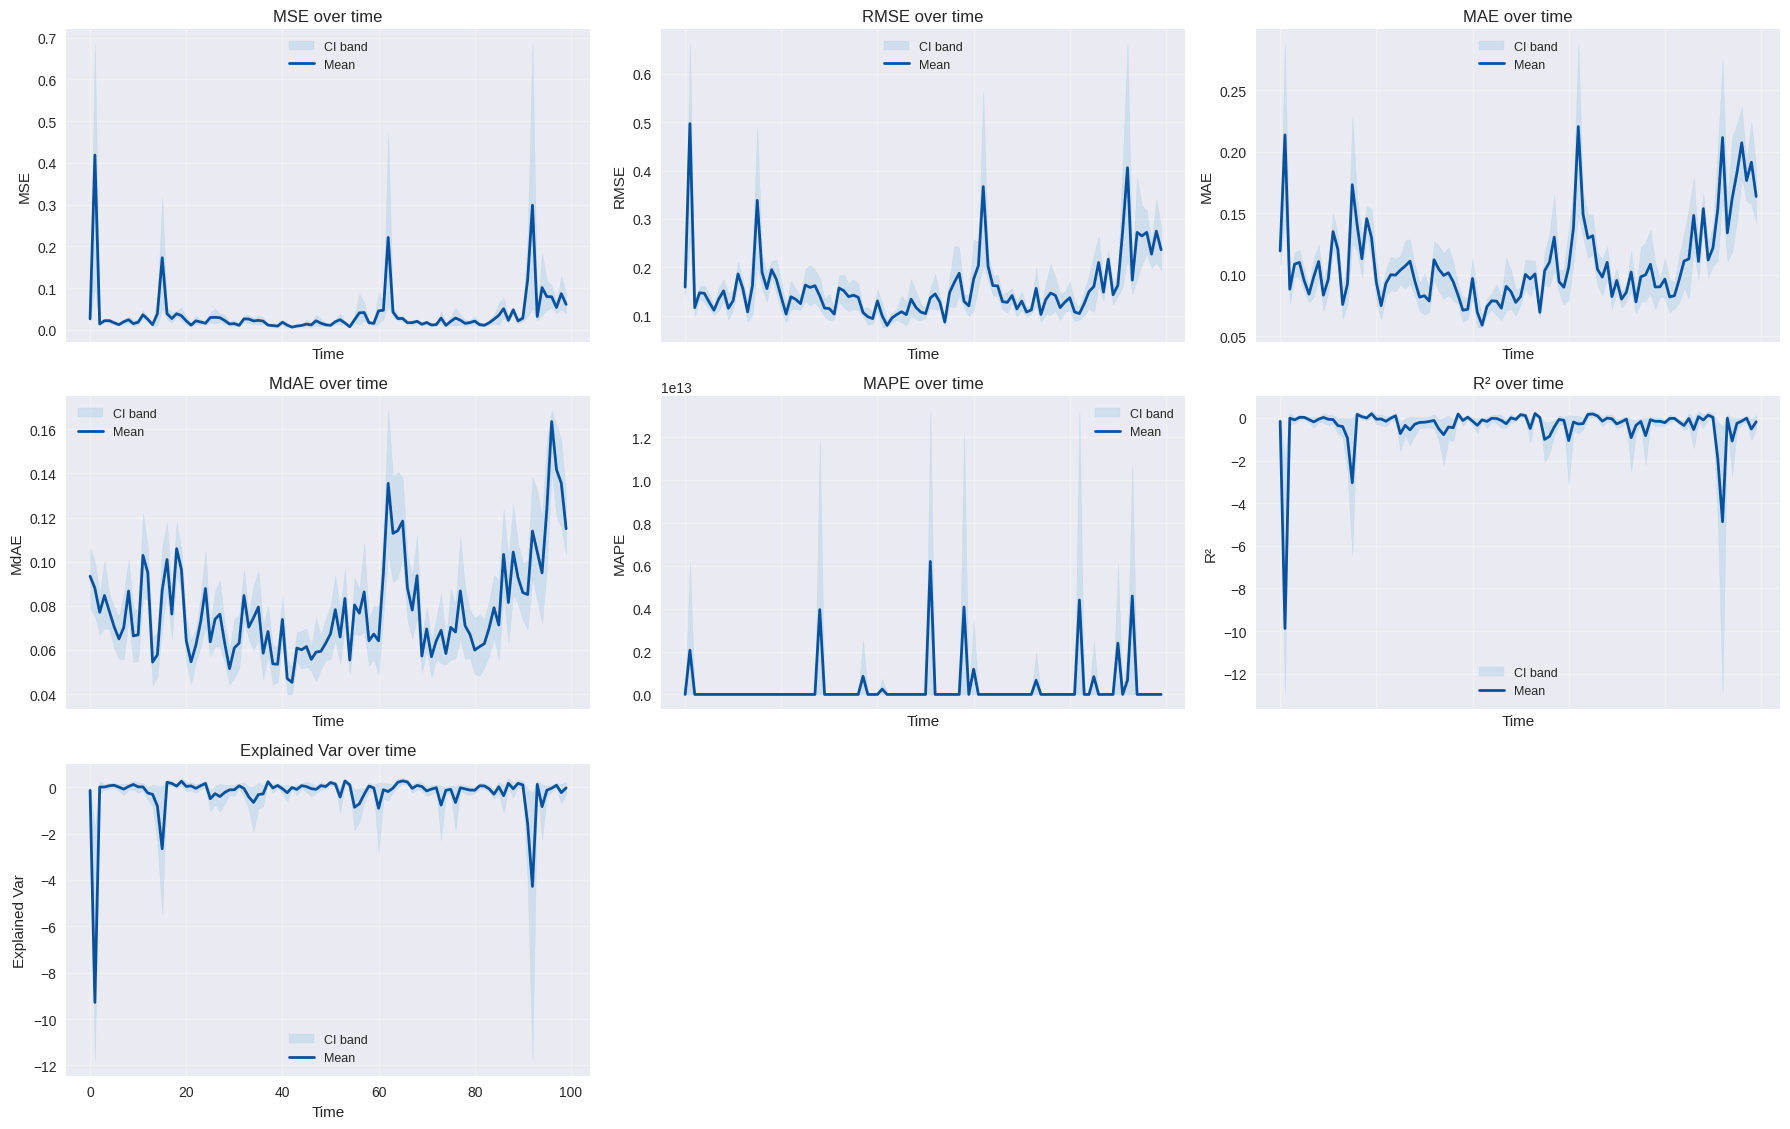

In [ ]:
# plot perf metrics over time series

num_cols = [c for c in np_metrics_df.columns if re.match(r'cv_.*_(mean|ci_lower|ci_upper)$', c)]
for c in num_cols:
    np_metrics_df[c] = (
        np_metrics_df[c].astype(str)
             .str.replace('\\', '', regex=False)  # remove backslashes
             .str.replace(',', '', regex=False)   # remove commas if present
             .str.strip()
    )
    np_metrics_df[c] = pd.to_numeric(np_metrics_df[c], errors='coerce')

# Time axis
np_metrics_df = np_metrics_df.sort_values('index') if 'index' in np_metrics_df.columns else np_metrics_df
np_metrics_df['t'] = np_metrics_df['index'] if 'index' in np_metrics_df.columns else np.arange(len(np_metrics_df))

# Metric triplets
triplets = [
    ('cv_MSE_mean','cv_MSE_ci_lower','cv_MSE_ci_upper','MSE'),
    ('cv_RMSE_mean','cv_RMSE_ci_lower','cv_RMSE_ci_upper','RMSE'),
    ('cv_MAE_mean','cv_MAE_ci_lower','cv_MAE_ci_upper','MAE'),
    ('cv_MdAE_mean','cv_MdAE_ci_lower','cv_MdAE_ci_upper','MdAE'),
    ('cv_MAPE_mean','cv_MAPE_ci_lower','cv_MAPE_ci_upper','MAPE'),
    ('cv_R2_mean','cv_R2_ci_lower','cv_R2_ci_upper','R²'),
    ('cv_EV_mean','cv_EV_ci_lower','cv_EV_ci_upper','Explained Var'),
]

# Long-form with safety checks
rows = []
for mean_col, lo_col, hi_col, label in triplets:
    if set([mean_col, lo_col, hi_col]).issubset(np_metrics_df.columns):
        sub = pd.DataFrame({
            't': np_metrics_df['t'],
            'metric': label,
            'mean': np_metrics_df[mean_col],
            'ci_lo': np_metrics_df[lo_col],
            'ci_hi': np_metrics_df[hi_col]
        })
        sub = sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['mean','ci_lo','ci_hi','t'])
        # Ensure ci_lo <= ci_hi
        swap = sub['ci_lo'] > sub['ci_hi']
        sub.loc[swap, ['ci_lo','ci_hi']] = sub.loc[swap, ['ci_hi','ci_lo']].values
        rows.append(sub)

long_df = pd.concat(rows, ignore_index=True)

# clip extremes (central 99% per metric)
clipped = []
for m in long_df['metric'].unique():
    d = long_df[long_df['metric'] == m].copy()
    lo_q, hi_q = d[['ci_lo','ci_hi']].stack().quantile([0.005, 0.995])
    d['ci_lo'] = d['ci_lo'].clip(lo_q, hi_q)
    d['ci_hi'] = d['ci_hi'].clip(lo_q, hi_q)
    d['mean']  = d['mean'].clip(lo_q, hi_q)
    clipped.append(d)
long_df = pd.concat(clipped, ignore_index=True)

# Plot
plt.style.use('seaborn-v0_8')
metrics = long_df['metric'].unique()
cols = 3
rows_n = int(np.ceil(len(metrics)/cols))
fig, axes = plt.subplots(rows_n, cols, figsize=(6*cols, 3.8*rows_n), sharex=True)
axes = np.array(axes).reshape(rows_n, cols)

for i, m in enumerate(metrics):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    sub = long_df[long_df['metric'] == m]
    ax.fill_between(sub['t'], sub['ci_lo'], sub['ci_hi'], color='#9ecae1', alpha=0.35, label='CI band')
    ax.plot(sub['t'], sub['mean'], color='#08519c', lw=2, label='Mean')
    ax.set_title(f'{m} over time')
    ax.set_xlabel('Time')
    ax.set_ylabel(m)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

# Remove unused axes
for j in range(i+1, rows_n*cols):
    fig.delaxes(axes[j//cols, j%cols])

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/data/perf_metrics_timeseries_with_CIs.jpeg', dpi=200, bbox_inches='tight')




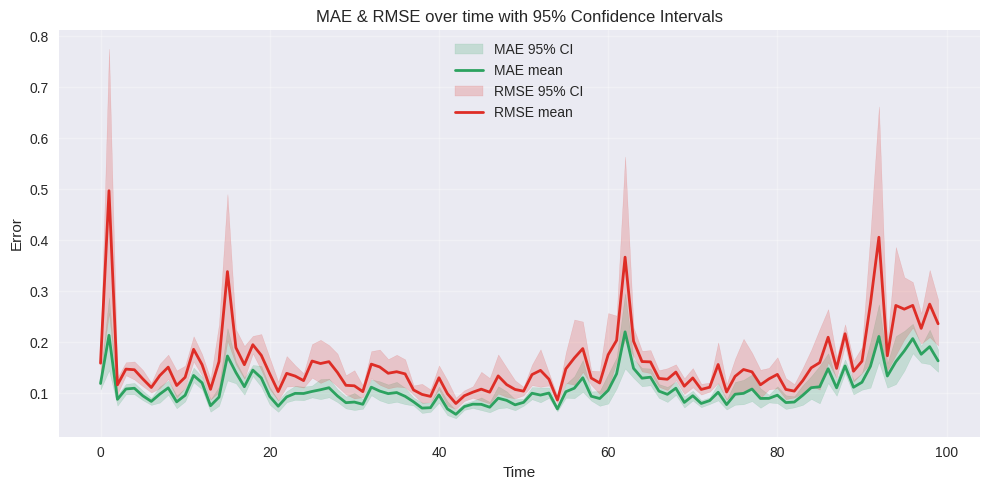

In [ ]:
# plot the MAE and RMSE for each optimal model selected by the grid search
# clean up column headers
np_metrics_df.columns = [c.strip() for c in np_metrics_df.columns]

# Clean numeric columns for MAE/RMSE
cols_to_clean = [
    'cv_MAE_mean', 'cv_MAE_ci_lower', 'cv_MAE_ci_upper',
    'cv_RMSE_mean', 'cv_RMSE_ci_lower', 'cv_RMSE_ci_upper'
]

for c in cols_to_clean:
    if c in np_metrics_df.columns:
        np_metrics_df[c] = (
            np_metrics_df[c].astype(str)
                            .str.replace('\\', '', regex=False)  # remove escaped signs like \+ or \-
                            .str.replace(',', '', regex=False)   # remove commas if any
                            .str.strip()
        )
        np_metrics_df[c] = pd.to_numeric(np_metrics_df[c], errors='coerce')

# Time axis
if 'index' in np_metrics_df.columns:
    np_metrics_df = np_metrics_df.sort_values('index')
    np_metrics_df['t'] = np_metrics_df['index']
else:
    np_metrics_df['t'] = np.arange(len(np_metrics_df))

# Prepare MAE and RMSE subset data
mae_df = np_metrics_df[['t', 'cv_MAE_mean', 'cv_MAE_ci_lower', 'cv_MAE_ci_upper']].dropna()
rmse_df = np_metrics_df[['t', 'cv_RMSE_mean', 'cv_RMSE_ci_lower', 'cv_RMSE_ci_upper']].dropna()

# Ensure CI bounds are ordered correctly
for d in (mae_df, rmse_df):
    swap_mask = d['cv_MAE_ci_lower'].gt(d['cv_MAE_ci_upper']) if 'cv_MAE_ci_lower' in d.columns else d['cv_RMSE_ci_lower'].gt(d['cv_RMSE_ci_upper'])
    if swap_mask.any():
        lo_col = [c for c in d.columns if 'ci_lower' in c][0]
        hi_col = [c for c in d.columns if 'ci_upper' in c][0]
        d.loc[swap_mask, [lo_col, hi_col]] = d.loc[swap_mask, [hi_col, lo_col]].values

# --- Plot MAE & RMSE with confidence intervals ---
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(10, 5))

# MAE plot
ax.fill_between(mae_df['t'], mae_df['cv_MAE_ci_lower'], mae_df['cv_MAE_ci_upper'],
                color='#2ca25f', alpha=0.20, label='MAE 95% CI')
ax.plot(mae_df['t'], mae_df['cv_MAE_mean'], color='#2ca25f', linewidth=2, label='MAE mean')

# RMSE plot
ax.fill_between(rmse_df['t'], rmse_df['cv_RMSE_ci_lower'], rmse_df['cv_RMSE_ci_upper'],
                color='#de2d26', alpha=0.20, label='RMSE 95% CI')
ax.plot(rmse_df['t'], rmse_df['cv_RMSE_mean'], color='#de2d26', linewidth=2, label='RMSE mean')

# Labels & styling
ax.set_title('MAE & RMSE over time with 95% Confidence Intervals')
ax.set_xlabel('Time')
ax.set_ylabel('Error')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/data/mae_rmse_timeseries.jpeg', dpi=200, bbox_inches='tight')


##### Review R-Squared

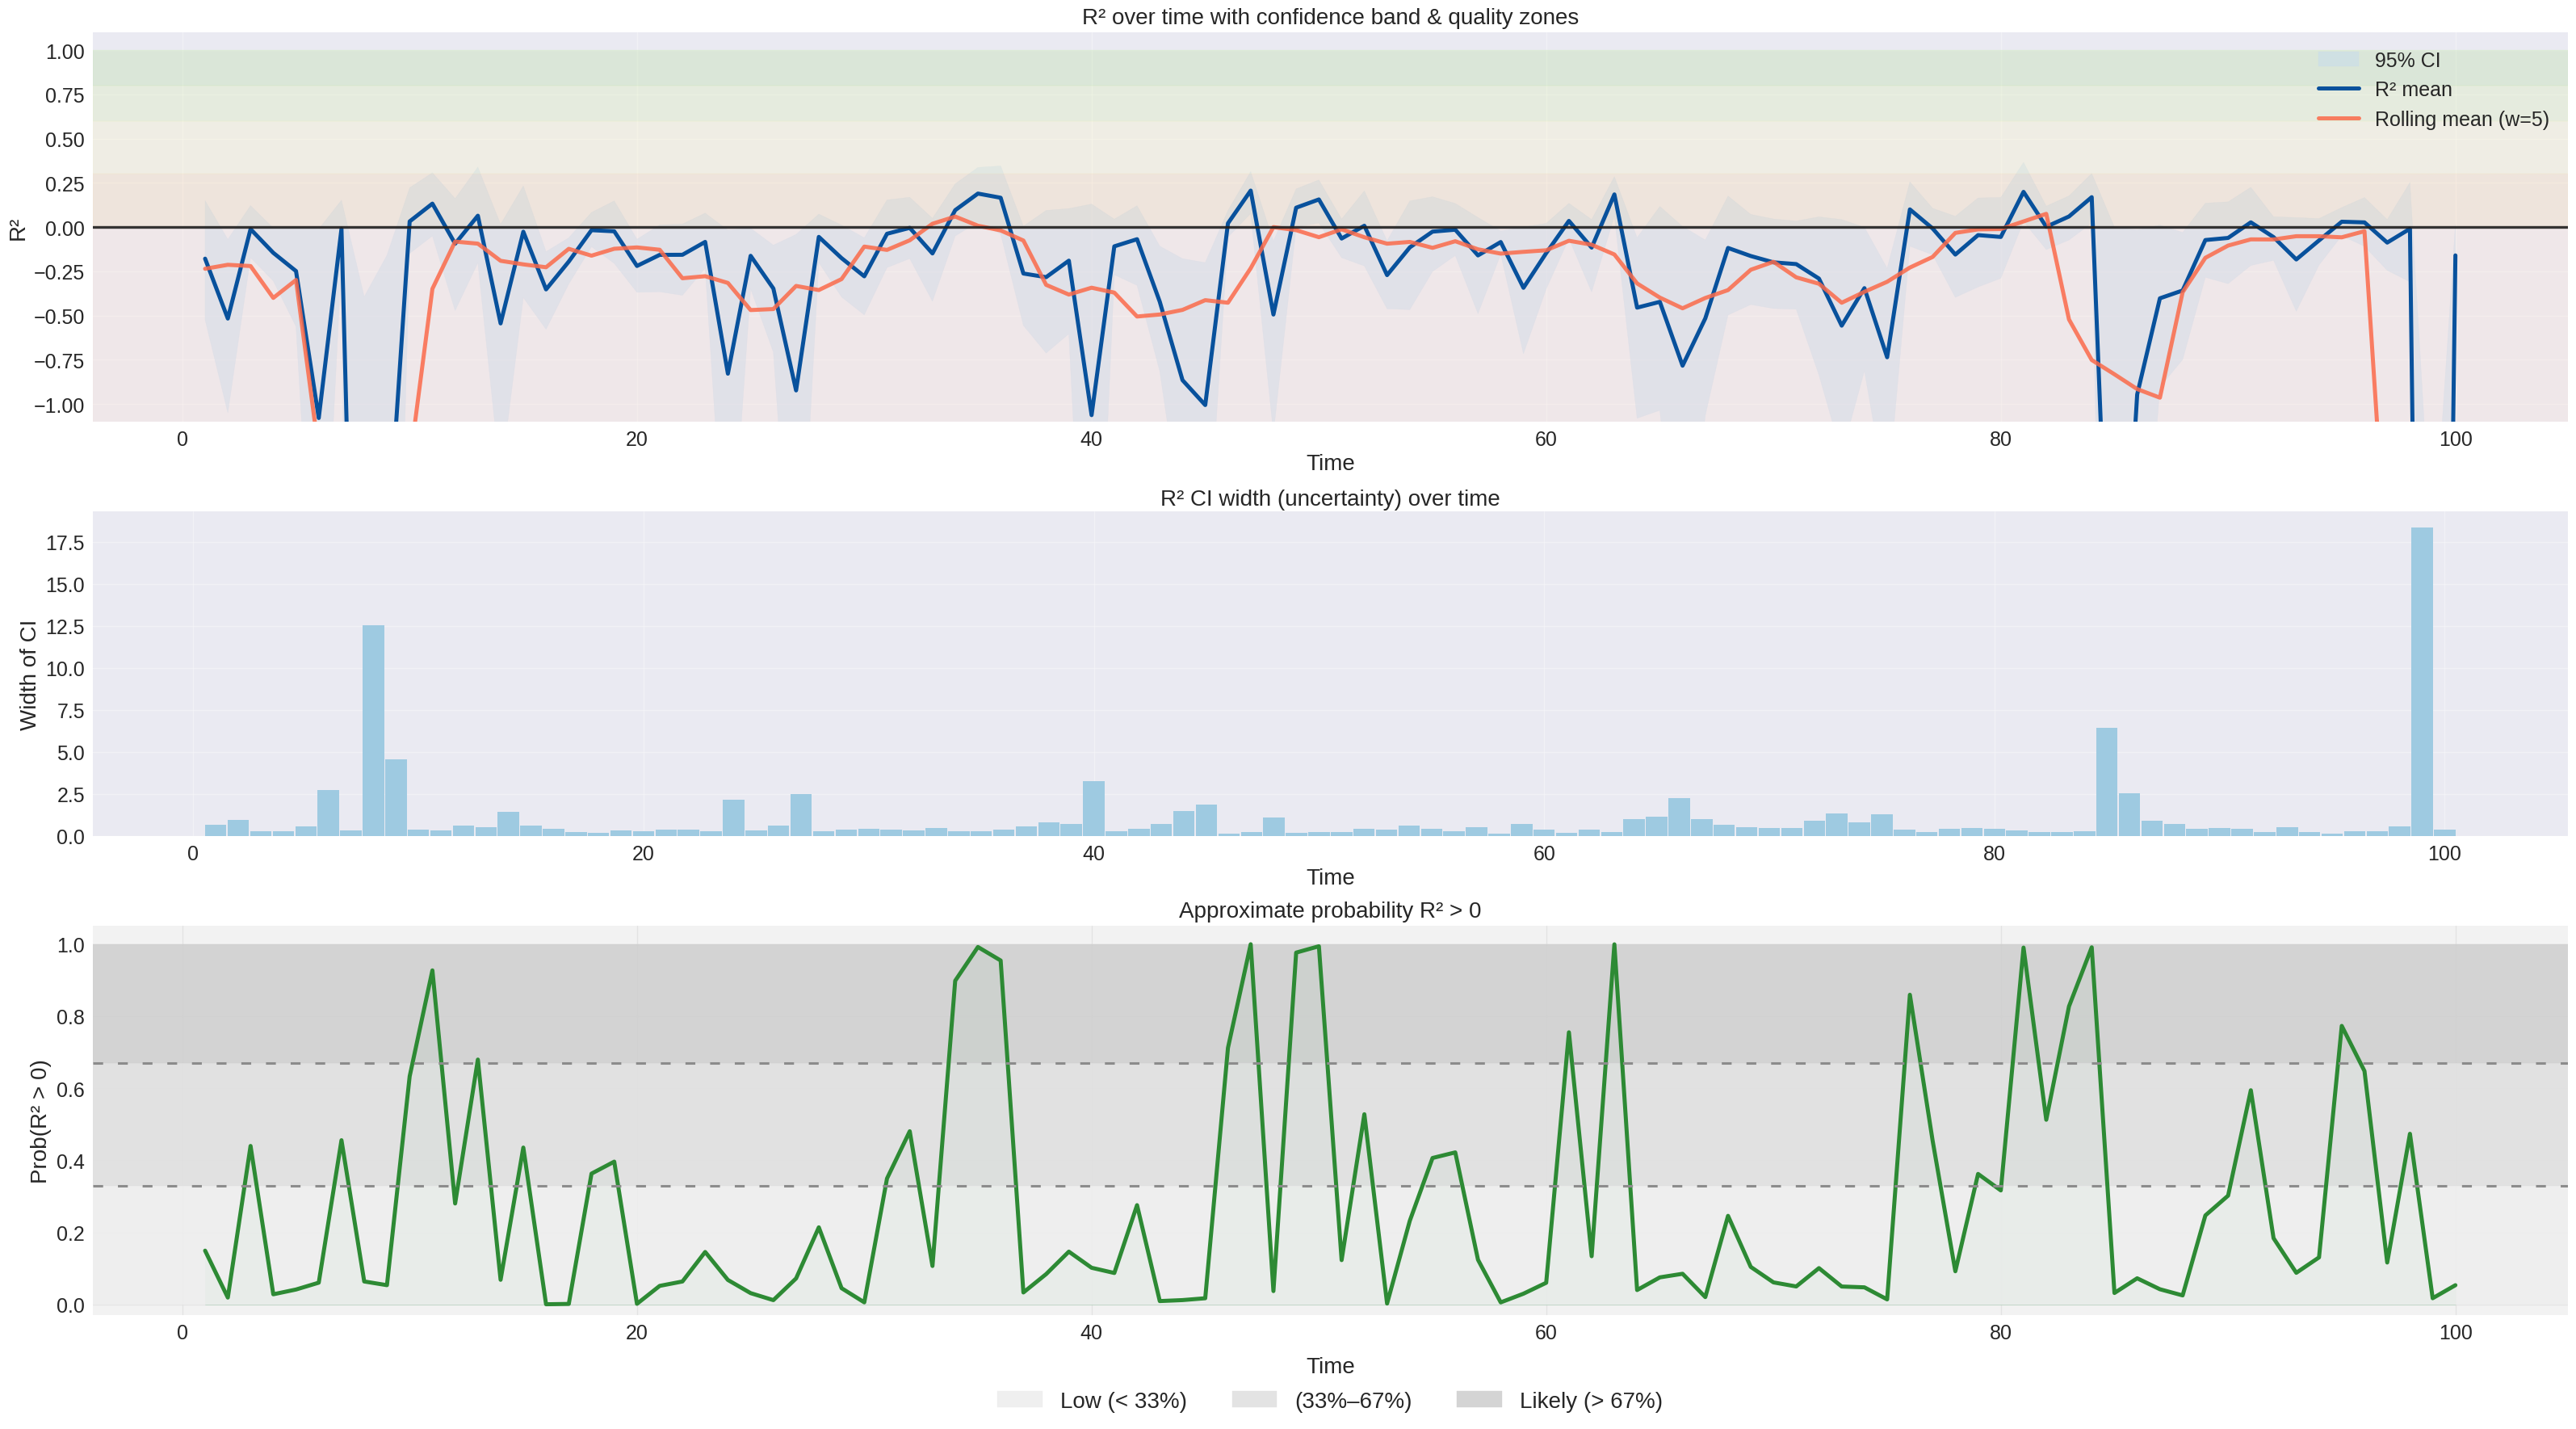

In [ ]:
# clean column headers
np_metrics_df.columns = [c.strip() for c in np_metrics_df.columns]
for c in ['cv_R2_mean','cv_R2_ci_lower','cv_R2_ci_upper']:
    np_metrics_df[c] = (
        np_metrics_df[c].astype(str)
                        .str.replace('\\', '', regex=False)
                        .str.replace(',', '', regex=False)
                        .str.strip()
    )
    np_metrics_df[c] = pd.to_numeric(np_metrics_df[c], errors='coerce')

# Time axis
if 'time_series' in np_metrics_df.columns:
    np_metrics_df = np_metrics_df.sort_values('time_series')
    np_metrics_df['t'] = np_metrics_df['time_series']
elif 'index' in np_metrics_df.columns:
    np_metrics_df = np_metrics_df.sort_values('index')
    np_metrics_df['t'] = np_metrics_df['index']
else:
    np_metrics_df['t'] = np.arange(len(np_metrics_df))

# calc CI width to get Probability that R²>0
ci_width = (np_metrics_df['cv_R2_ci_upper'] - np_metrics_df['cv_R2_ci_lower']).abs()
SE = ci_width / (2 * 1.96)
SE = SE.replace(0, np.nan)
prob_pos = 1 - norm.cdf((0 - np_metrics_df['cv_R2_mean']) / SE)

# Rolling mean for Panel 1
roll_mean = np_metrics_df['cv_R2_mean'].rolling(window=5, min_periods=1, center=True).mean()

# Build plot
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(32, 18), constrained_layout=False)

# grid
gs = GridSpec(nrows=3, ncols=1, figure=fig, height_ratios=[1.2, 1.0, 1.2])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# Reduce vertical whitespace between panels
fig.subplots_adjust(hspace=0.08, top=0.97, bottom=0.06, left=0.08, right=0.98)


# Panel 1: R² over time (centered around 0)

ax1.fill_between(np_metrics_df['t'], np_metrics_df['cv_R2_ci_lower'], np_metrics_df['cv_R2_ci_upper'],
                 color='#c6dbef', alpha=0.5, label='95% CI')
ax1.plot(np_metrics_df['t'], np_metrics_df['cv_R2_mean'], color='#08519c', lw=3.6, label='R² mean')
ax1.plot(np_metrics_df['t'], roll_mean, color='#fb6a4a', lw=3.6, alpha=0.85, label='Rolling mean (w=5)')
ax1.set_title('R² over time with confidence band & quality zones', pad=8, fontsize=20)
ax1.set_ylabel('R²', fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.grid(True, alpha=0.35)
for lo, hi, color in [(-1e3,0.0,'#fee0d2'), (0.0,0.3,'#fdd49e'),
                      (0.3,0.6,'#fff7bc'), (0.6,0.8,'#d9f0a3'), (0.8,1.0,'#addd8e')]:
    ax1.axhspan(lo, hi, color=color, alpha=0.25)
r2_lo = float(np.nanmin(np_metrics_df['cv_R2_ci_lower']))
r2_hi = float(np.nanmax(np_metrics_df['cv_R2_ci_upper']))
margin = 0.06
span = max(abs(r2_lo), abs(r2_hi)) + margin
span = min(max(span, 0.6), 1.10)
ax1.set_ylim(-span, span)
ax1.axhline(0.0, color='#1f1f1f', lw=2.4, alpha=0.9)
ax1.legend(loc='upper right', fontsize=18)

# Panel 2: CI width (uncertainty)
ax2.bar(np_metrics_df['t'], ci_width, color='#9ecae1', width=0.95)
ax2.set_title('R² CI width (uncertainty) over time', pad=6, fontsize=20)
ax2.set_ylabel('Width of CI', fontsize=20)
ax2.set_xlabel('Time', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.grid(True, alpha=0.35)

# Panel 3: Probability R² > 0
ax3.set_facecolor('#f2f2f2')
ax3.plot(np_metrics_df['t'], prob_pos, color='#2d8a34', lw=3.6)
ax3.fill_between(np_metrics_df['t'], 0, prob_pos, color='#31a354', alpha=0.28)
ax3.set_title('Approximate probability R² > 0', pad=8, fontsize=20)
ax3.set_ylabel('Prob(R² > 0)', fontsize=20)
ax3.set_xlabel('Time', fontsize=20, labelpad=12)
ax3.set_ylim(-0.03, 1.05)
ax3.tick_params(axis='both', which='major', labelsize=18)
ax3.grid(True, color='#dddddd', alpha=0.7)
low_hi, high_lo = 0.33, 0.67
ax3.axhspan(0.0, low_hi,  color='#eeeeee', alpha=0.9, label='Low (< 33%)')
ax3.axhspan(low_hi, high_lo, color='#e0e0e0', alpha=0.9, label='(33%–67%)')
ax3.axhspan(high_lo, 1.0,  color='#d0d0d0', alpha=0.9, label='Likely (> 67%)')
ax3.axhline(low_hi,  color='#8c8c8c', lw=2.2, ls=(0, (4, 6)))
ax3.axhline(high_lo, color='#8c8c8c', lw=2.2, ls=(0, (4, 6)))
ax3.legend(loc='lower center', bbox_to_anchor=(0.5, -0.30), ncol=3, frameon=False, fontsize=20)


plt.tight_layout()
fig.savefig('/content/drive/MyDrive/data/r2_insights.png', bbox_inches='tight')



#### EXPERIMENT 2(a): EVALUATE ANY TREND IN SHAP VALUE TIME-SERIES FOR ALL FINANCIALS

In [ ]:
all_shap_df.head(2)

index           feature  shap_val_mean  time_series
0      1  accounts_payable        0.00000          100
1      1      acquisitions        0.00019          100

In [ ]:
# run mann kendall hypothesis testing for each predictor feature's
# shap to identify any trend in Time Series

# sort shap values by feature and index in descending order for MK Test;
# Q4 2024 starts at index 1 for each ticker symbol
all_shap_df = all_shap_df.sort_values(by=['feature', 'time_series'], ascending=[True, False])

# create a dataframe to hold feature and respective mann kendall p-val and test stat

# create empty lists to hold hypothesis testing metrics
mk_features = []
mk_pvals = []
mk_slopes = []
mk_trend_detections = []
mk_trends = []
mk_taus = []


for feature in all_shap_df.feature.unique():
  # perform hypo testing on each predictive feature's shap values
  feat_result = mk.original_test(all_shap_df['feature']==feature)

  # pull slope, trend, and p-value from each shap and attach to list for df creation
  mk_feat = feature
  mk_features.append(mk_feat)

  mk_slope = feat_result.slope
  mk_slopes.append(mk_slope)

  mk_trend = feat_result.trend
  mk_trends.append(mk_trend)

  mk_pval = feat_result.p
  mk_pvals.append(mk_pval)

  mk_trend_detection = feat_result.h
  mk_trend_detections.append(mk_trend_detection)

  mk_tau = feat_result.Tau
  mk_taus.append(mk_tau)

mk_output_dict = {'features':mk_features,
                  'trend_detected':mk_trend_detections,
                  'slopes':mk_slopes,
                  'trends':mk_trends,
                  'pvals':mk_pvals,
                  'strength':mk_taus
                  }
mk_test_df = pd.DataFrame.from_dict(mk_output_dict)

# Check Average standard deviation for each individual variable's shap vals
all_shap_stats_df = (all_shap_df.groupby(['feature'], as_index=False)
                               .agg(shap_feat_avg=('shap_val_mean', np.mean),
                                    shap_feat_std=('shap_val_mean', np.std))
                    )
all_shap_stats_df.head()

/tmp/ipython-input-754487649.py:53: FutureWarning: The provided callable <function mean at 0x7b8a2bfd3880> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(shap_feat_avg=('shap_val_mean', np.mean),
/tmp/ipython-input-754487649.py:53: FutureWarning: The provided callable <function std at 0x7b8a2bfd39c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .agg(shap_feat_avg=('shap_val_mean', np.mean),


feature  shap_feat_avg  shap_feat_std
0      accounts_payable       0.000488       0.001493
1          acquisitions       0.000334       0.000494
2  book_value_per_share       0.001018       0.001796
3         buyback_yield       0.000454       0.000581
4  capital_expenditures       0.001144       0.002843

In [ ]:
# Calc if trends are significant or not using Bonferonni Correction to alpha value

# establish original p-value for hypothesis testing at 5%
original_sig_val = 0.05
# calculate correction significance value using Bonferroni Correction
alpha_correction = original_sig_val/len(mk_test_df)
mk_test_df['significant'] = mk_test_df['pvals']<alpha_correction

# split data into decreasing, increasing, and no trends dataframes
# keep only those features considered significant
mk_decr_df = mk_test_df[(mk_test_df['trends']=='decreasing')&(mk_test_df['significant']==True)]
mk_incr_df = mk_test_df[(mk_test_df['trends']=='increasing')&(mk_test_df['significant']==True)]
mk_none_df = mk_test_df[mk_test_df['trends']=='no trend']

# sort increasing/decreasing each each by strength
mk_decr_df = mk_decr_df.sort_values(by='strength', ascending=False)
mk_incr_df = mk_incr_df.sort_values(by='strength', ascending=False)

##### Visualize the insights from the Mann-Kendall tests for each feature's SHAP value

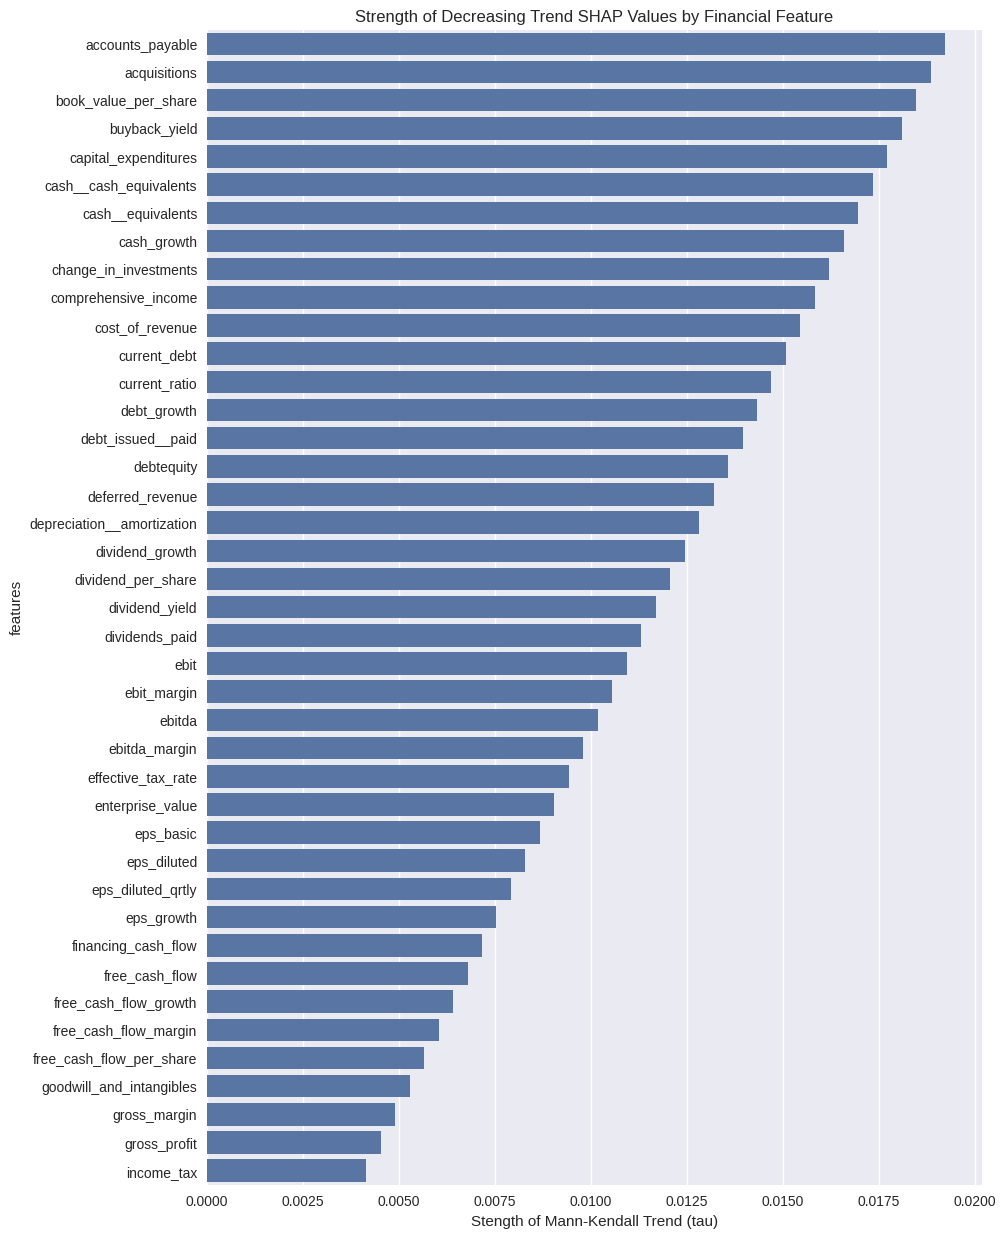

In [ ]:
# Visualize Mann-Kendall strength for those financial features with Decreasing Importance
# take absolute value of Mann-Kendall strength for visualization purposes
# This is only for decreasing trends
mk_decr_df_viz = mk_decr_df.copy()
mk_decr_df_viz['strength'] = mk_decr_df_viz['strength'].abs()
mk_decr_df_viz = mk_decr_df_viz.sort_values(by='strength', ascending=False)

plt.figure(figsize=(10,15))
sns.barplot(data=mk_decr_df_viz.sort_values(by='strength', ascending=False),
            y='features',
            x='strength'
            )
plt.title('Strength of Decreasing Trend SHAP Values by Financial Feature')
plt.xlabel('Stength of Mann-Kendall Trend (tau)')
plt.savefig('/content/drive/MyDrive/data/tau_decreasing_all_features.jpeg')
plt.show()

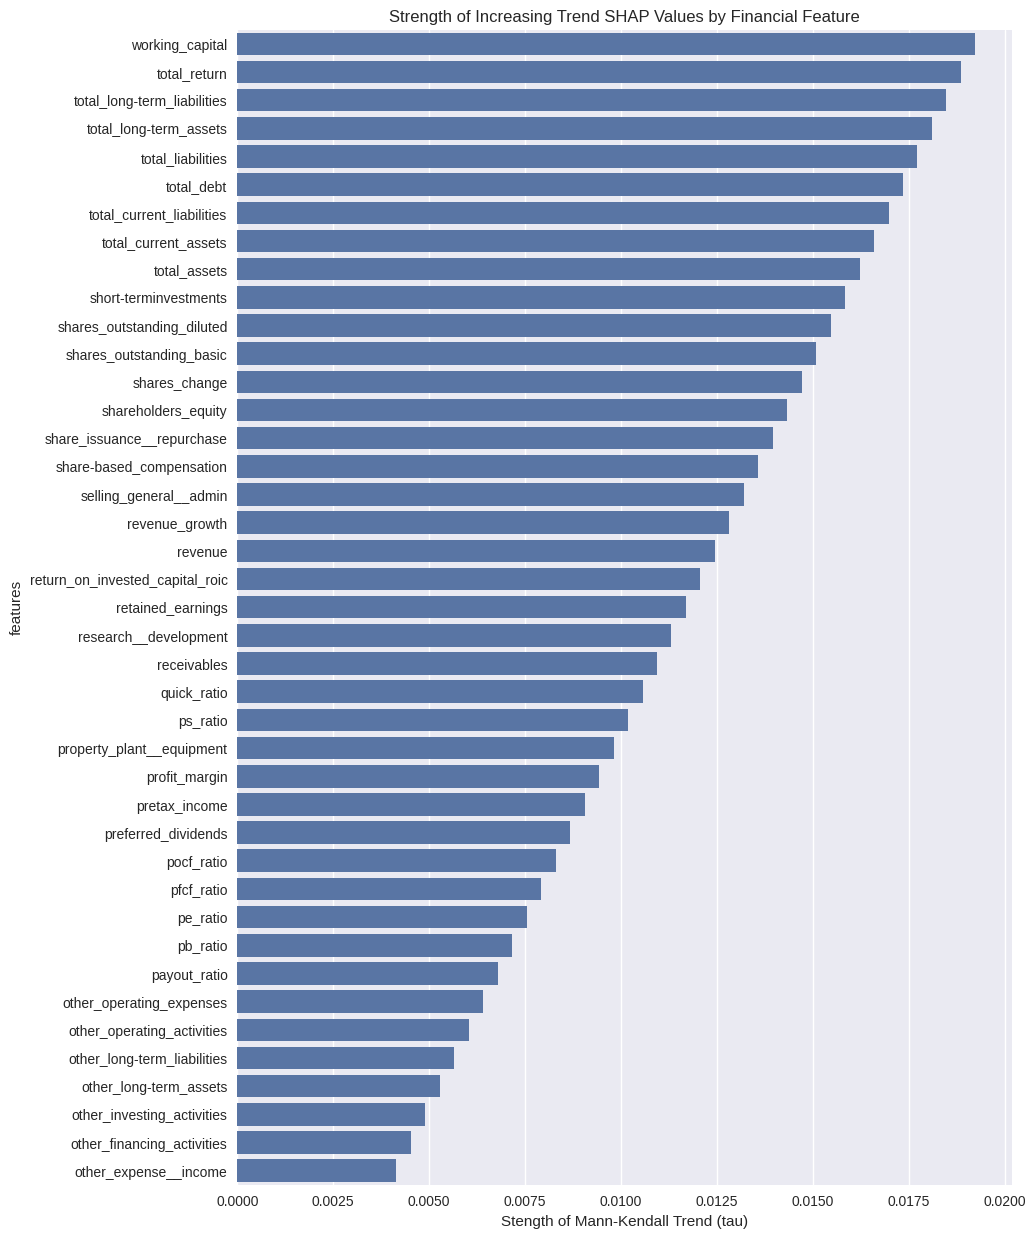

In [ ]:
# Visualize Mann-Kendall strength for those financial features with Increasing Importance
mk_incr_df_viz = mk_incr_df.copy()

plt.figure(figsize=(10,15))
sns.barplot(data=mk_incr_df_viz.sort_values(by='strength', ascending=False),
            y='features',
            x='strength'
            )
plt.title('Strength of Increasing Trend SHAP Values by Financial Feature')
plt.xlabel('Stength of Mann-Kendall Trend (tau)')
plt.savefig('/content/drive/MyDrive/data/tau_increasing_all_features.jpeg')
plt.show()

In [ ]:
# calculate mean and standard deviation SHAP values for each feature
# mean SHAP values present features with highest SHAP values over the study period
shap_mean_by_features = (all_shap_df.groupby(['feature'], as_index=False)
                                    .agg(shap_feat_mean=('shap_val_mean', np.mean))
                                    .reset_index()
                        )
# standard deviation SHAP values present features with highest SHAP values fluctuation over the study period
shap_std_by_features = (all_shap_df.groupby(['feature'], as_index=False)
                                   .agg(shap_feat_std=('shap_val_mean', np.std))
                                   .reset_index()
                        )

# drop index columns
shap_mean_by_features = shap_mean_by_features.drop(columns=['index'])
shap_std_by_features = shap_std_by_features.drop(columns=['index'])


# plot top features based off highest absolute shap values
top_n = 10
top_mean_shap_feat_df = shap_mean_by_features.nlargest(top_n, 'shap_feat_mean')
top_std_shap_feat_df = shap_std_by_features.nlargest(top_n, 'shap_feat_std')

# Collect feature names with highest mean and standard deviation
top_mean_shap_features = top_mean_shap_feat_df.feature.unique().tolist()
top_std_shap_features = top_std_shap_feat_df.feature.unique().tolist()



/tmp/ipython-input-3983851138.py:4: FutureWarning: The provided callable <function mean at 0x7b8a2bfd3880> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(shap_feat_mean=('shap_val_mean', np.mean))
/tmp/ipython-input-3983851138.py:9: FutureWarning: The provided callable <function std at 0x7b8a2bfd39c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .agg(shap_feat_std=('shap_val_mean', np.std))


In [ ]:
top_mean_shap_features

['market_cap_growth',
 'dividend_yield',
 'revenue_growth',
 'pe_ratio',
 'ps_ratio',
 'revenue',
 'eps_diluted',
 'shares_change',
 'selling_general__admin',
 'shares_outstanding_basic']

In [ ]:
all_shap_df.head()

index           feature  shap_val_mean  time_series
0        1  accounts_payable       0.000000          100
103      2  accounts_payable       0.002243           99
206      3  accounts_payable       0.000036           98
309      4  accounts_payable       0.000937           97
412      5  accounts_payable       0.000171           96

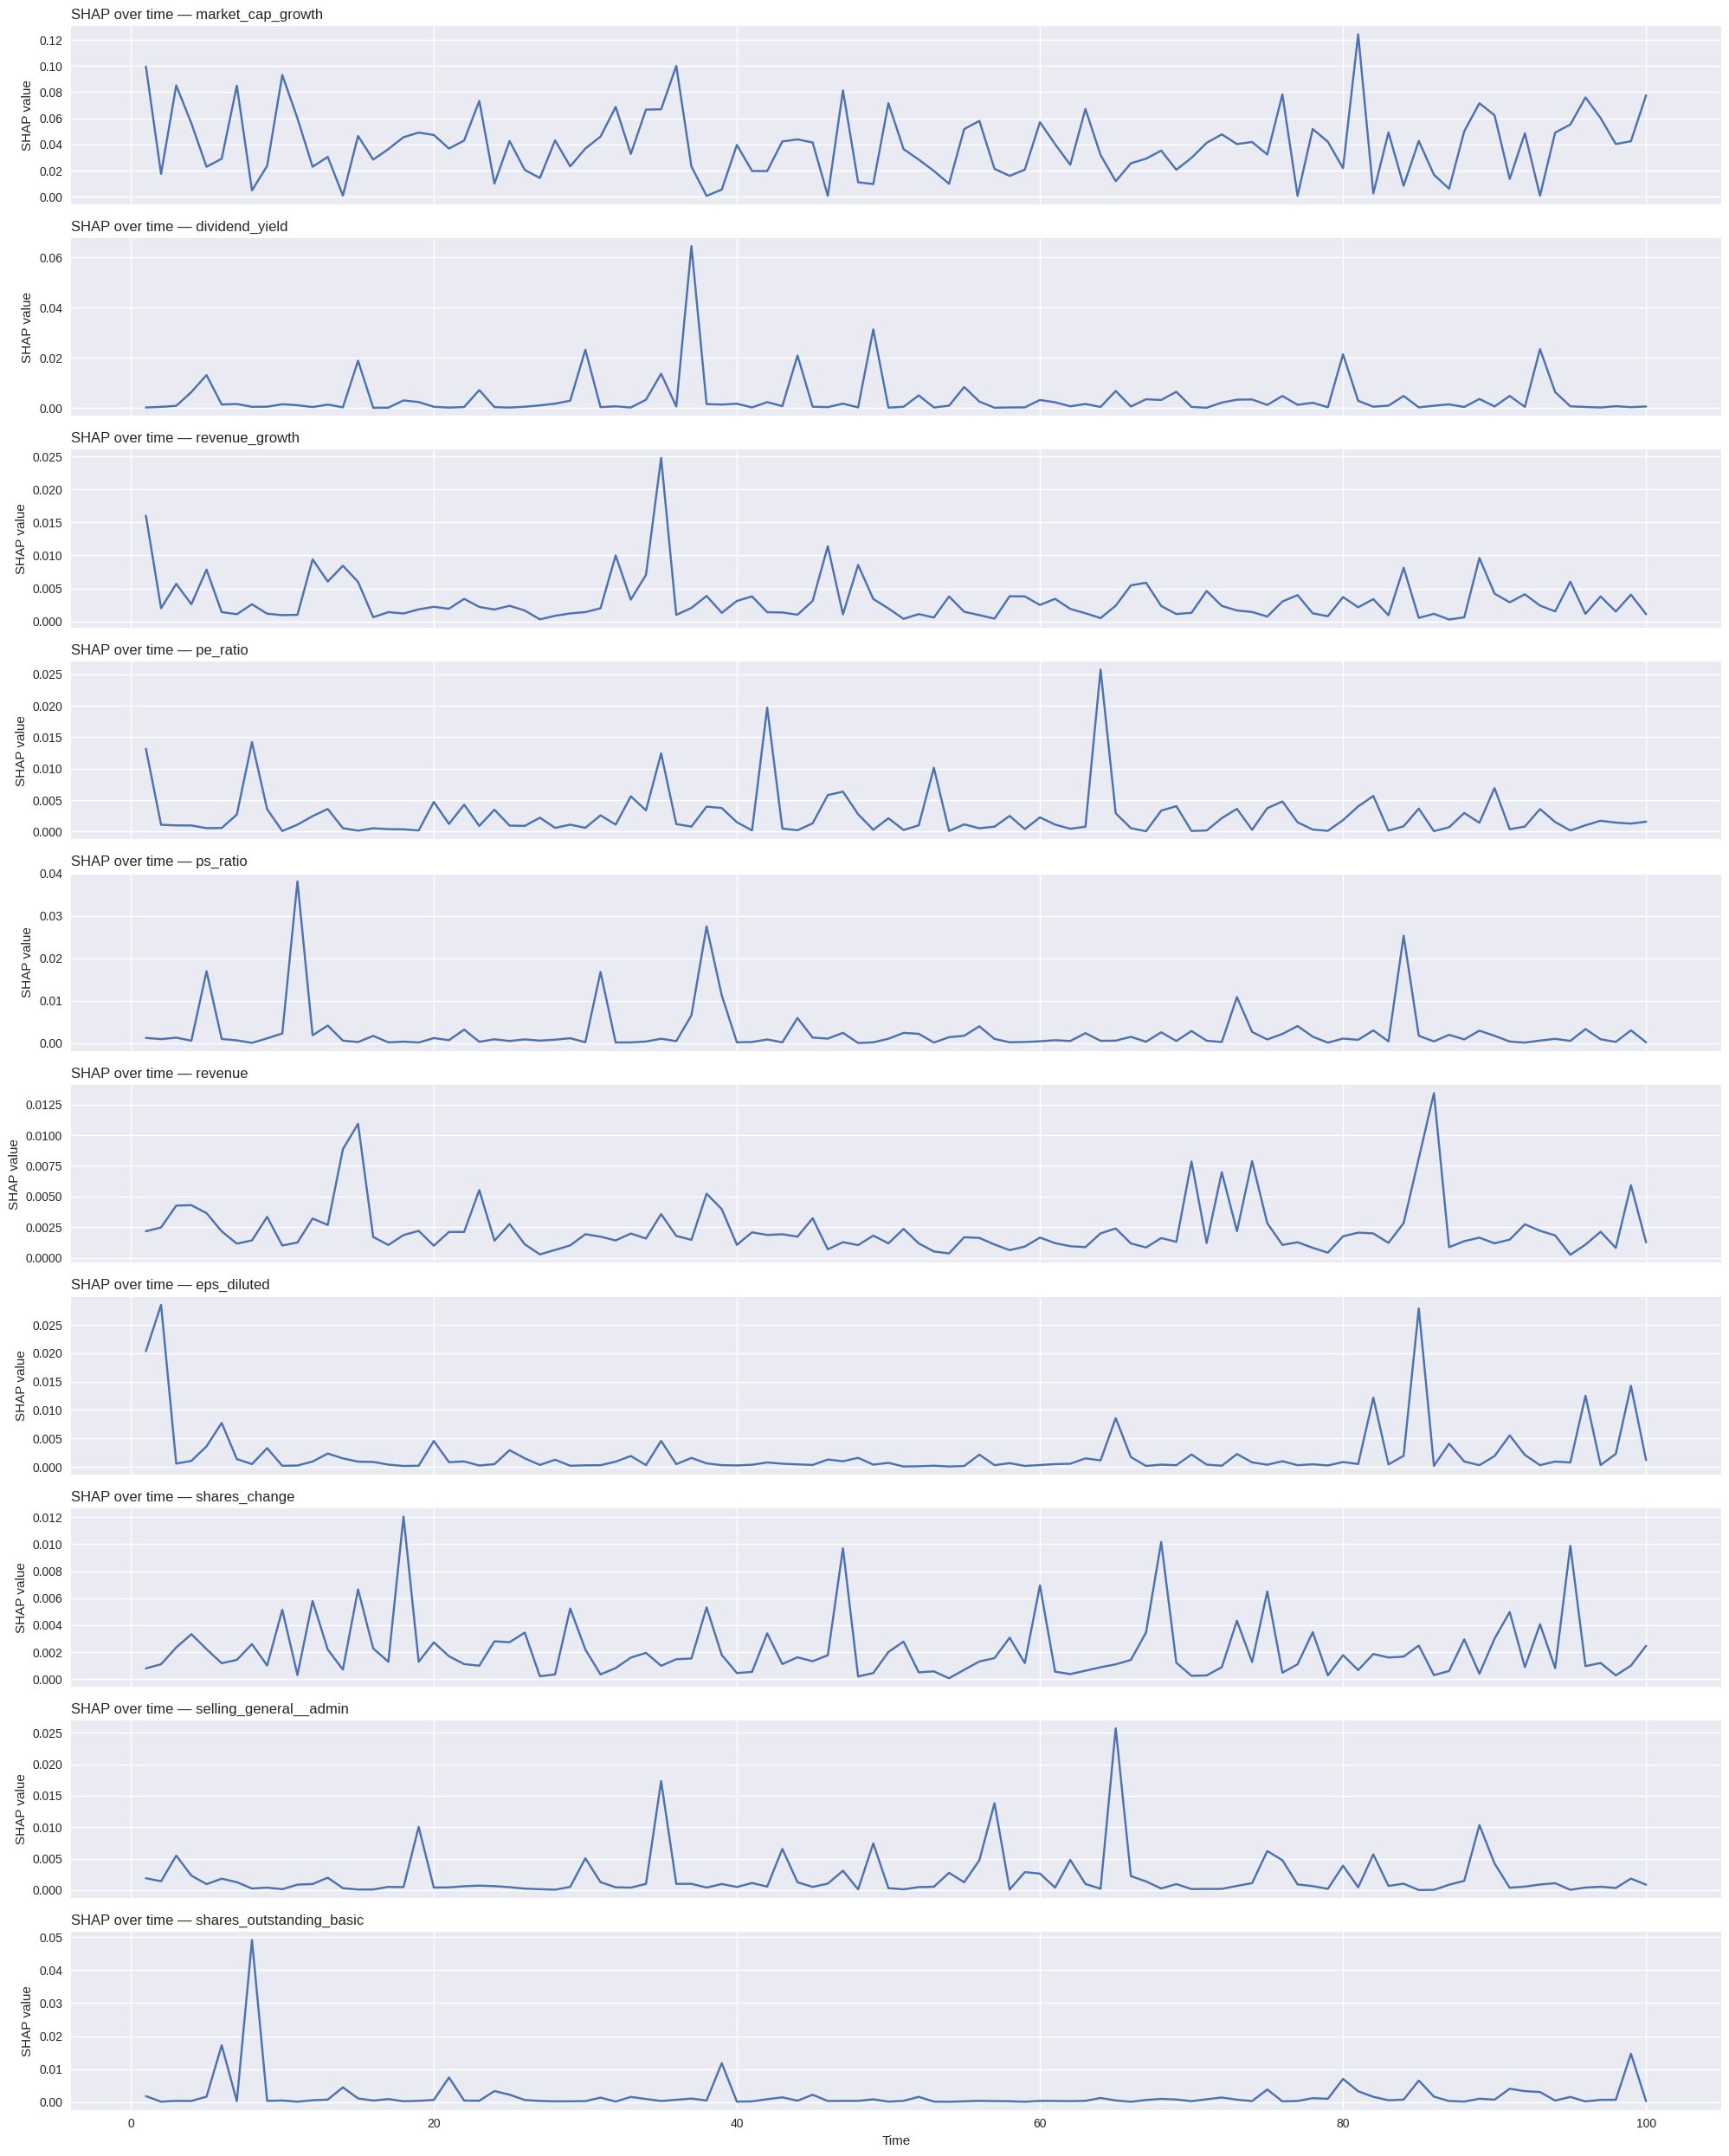

In [ ]:
# Visualize each line chart for the features with the top 10 highest SHAP mean
fig, axes = plt.subplots(nrows=top_n, ncols=1, figsize=(20, 2.5*top_n), sharex=True)

for i, feature in enumerate(top_mean_shap_features):
    ax = axes[i]
    data = all_shap_df[all_shap_df['feature'] == feature]

    sns.lineplot(
        data=data,
        x='time_series',
        y='shap_val_mean',
        ax=ax
    )

    ax.set_title(f"SHAP over time — {feature}", loc='left')
    ax.set_ylabel("SHAP value")
    ax.legend_.remove() if ax.get_legend() else None
    sns.despine(ax=ax)

axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/data/shap_mean_by_features.jpeg')
plt.show()


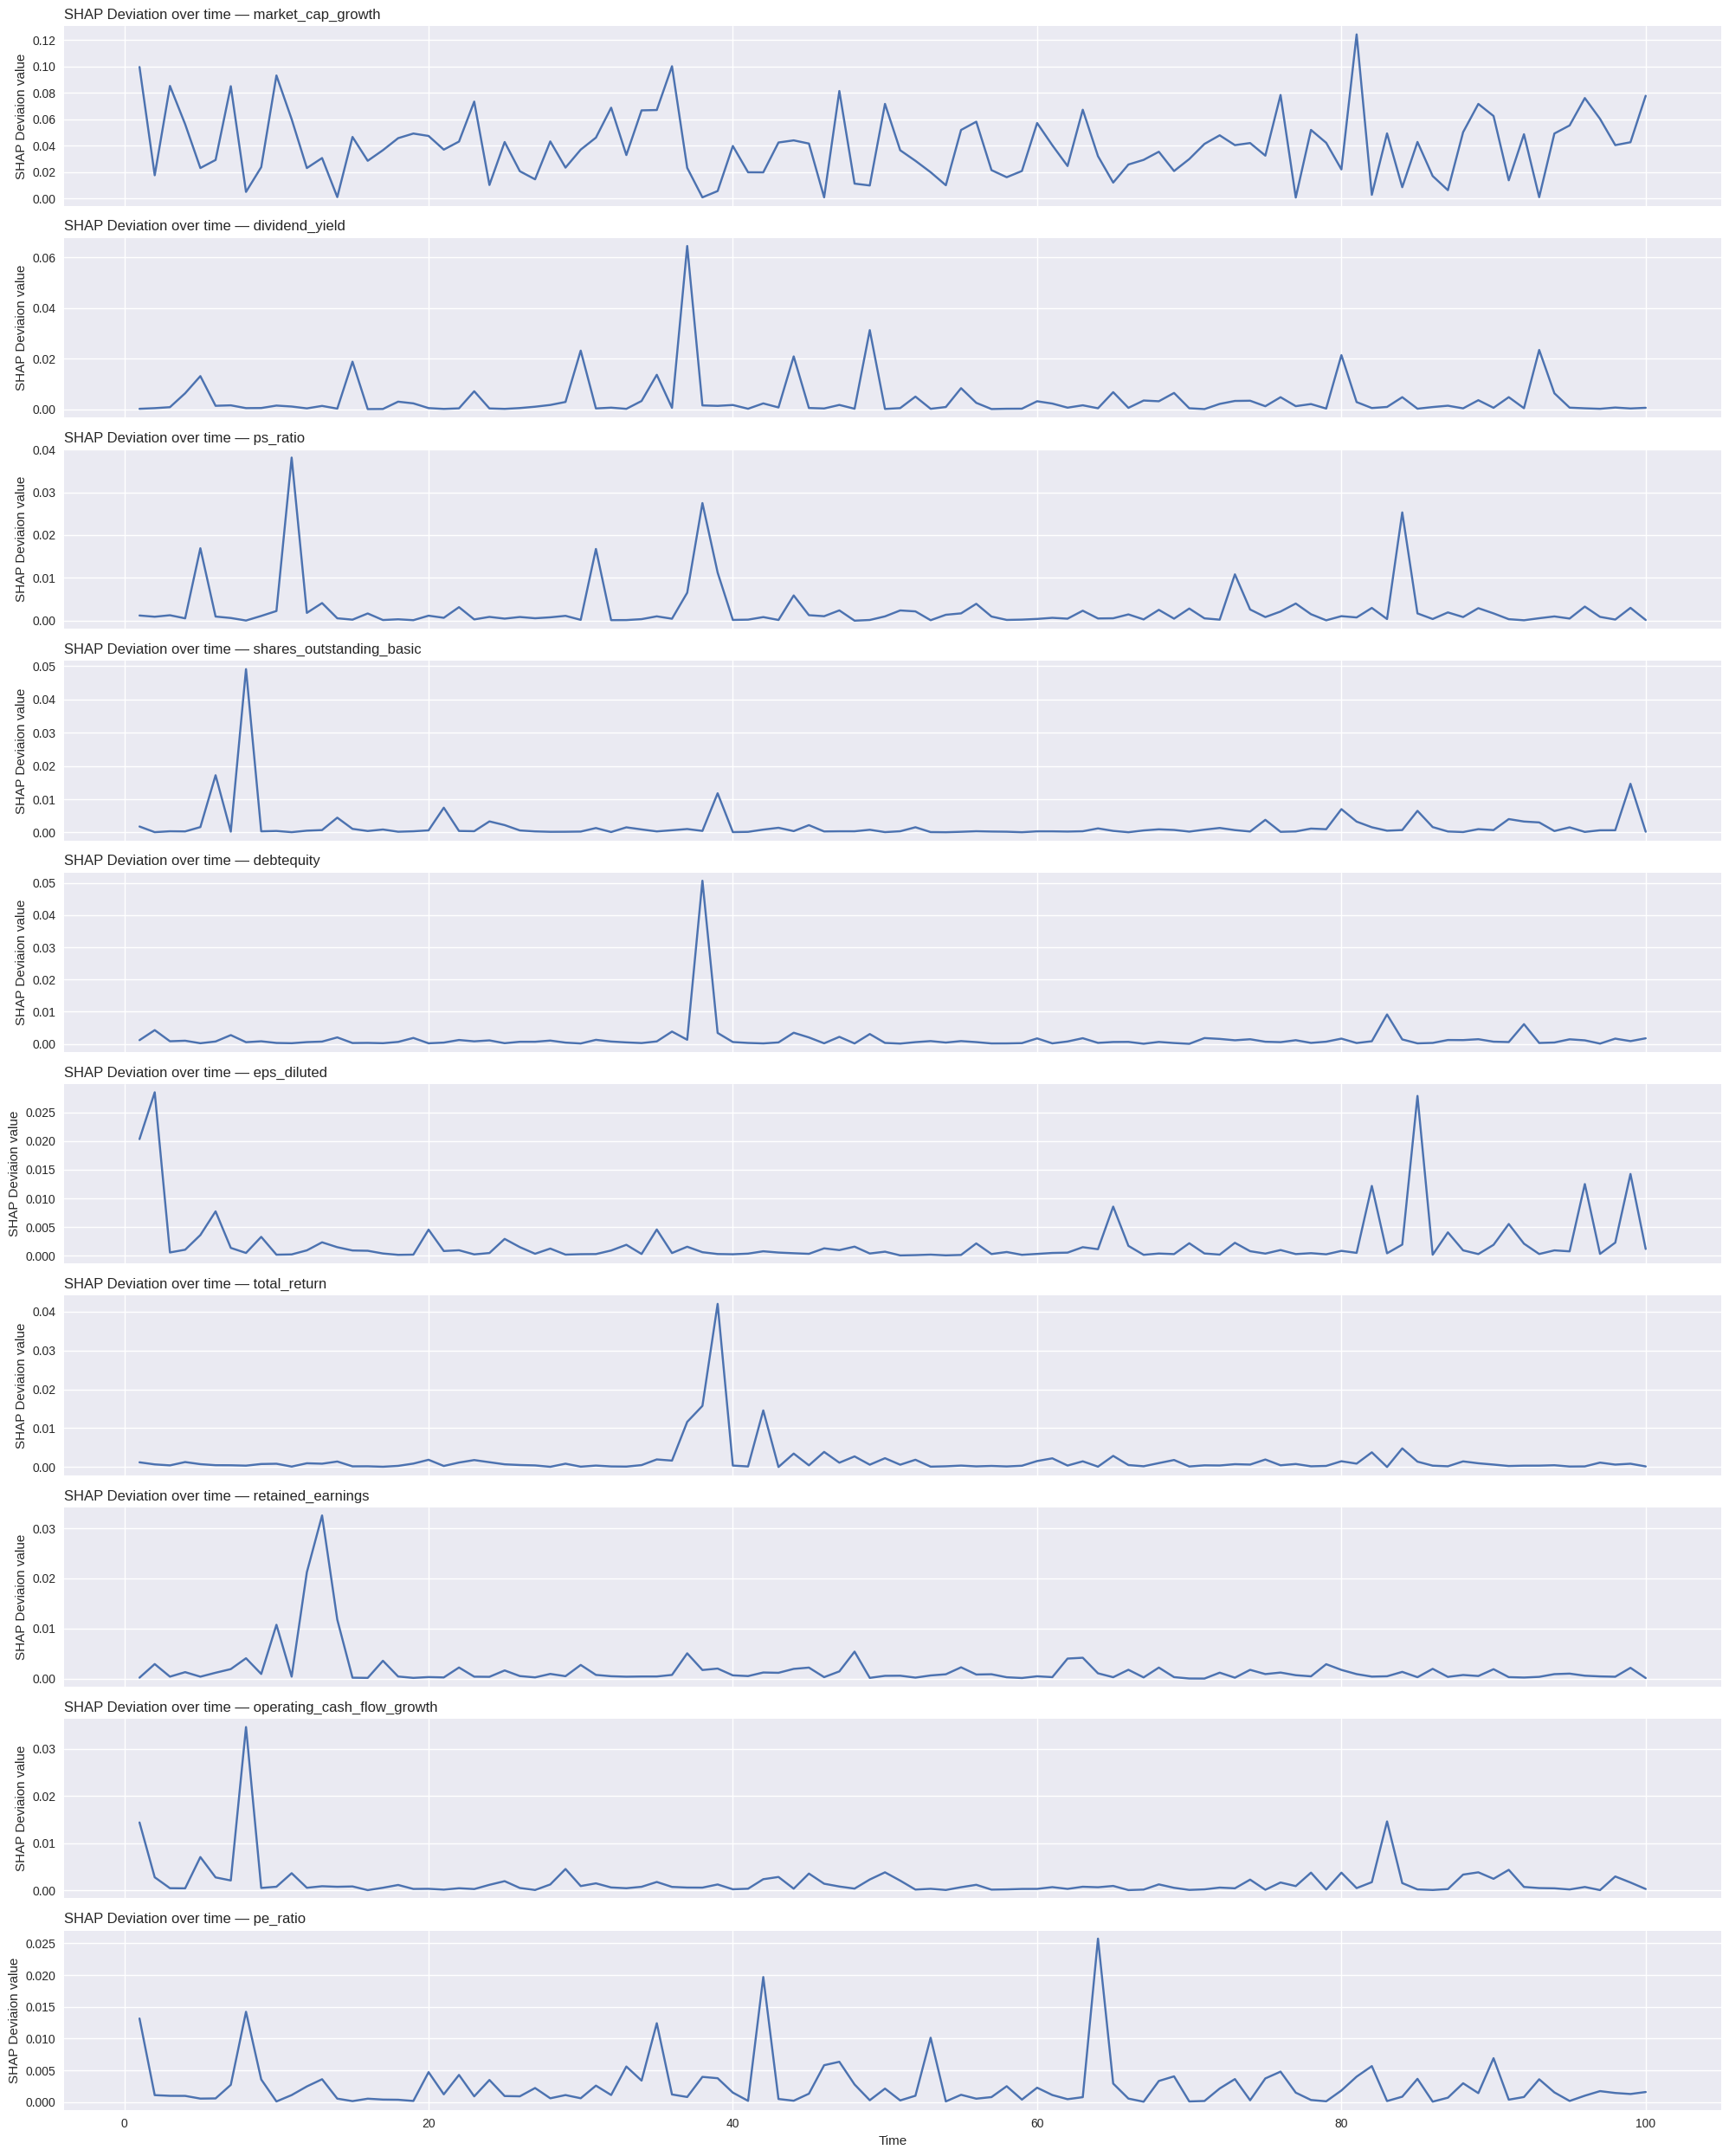

In [ ]:

# Visualize each line chart for the features with the top 10 highest SHAP standard deviations
# The below presents the 10 features with the highest standard deviations over the time period.
# Purpose here is to identify where high volatility occurs
fig, axes = plt.subplots(nrows=top_n, ncols=1, figsize=(20, 2.5*top_n), sharex=True)

for i, feature in enumerate(top_std_shap_features):
    ax = axes[i]
    data = all_shap_df[all_shap_df['feature'] == feature]

    sns.lineplot(
        data=data,
        x='time_series',
        y='shap_val_mean',
        ax=ax
    )

    ax.set_title(f"SHAP Deviation over time — {feature}", loc='left')
    ax.set_ylabel("SHAP Deviaion value")
    ax.legend_.remove() if ax.get_legend() else None
    sns.despine(ax=ax)


axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/data/shap_std_by_features.jpeg')
plt.show()


#### EXPERIMENT 2(b): EVALUATE ANY TREND IN SHAP VALUE TIME-SERIES FOR ALL FINANCIALS EXCEPT THOSE DERIVED FROM SHARE PRICE

In [ ]:

# run mann kendall hypothesis testing for each predictor feature's
# shap to identify any trend in Time Series
# predictors include all financials variables but exclude any derived from share price

# sort shap values by feature and index in descending order for MK Test;
# Q4 2024 starts at index 1 for each ticker symbol
shap_no_price_vars_df = shap_no_price_vars_df.sort_values(by=['feature', 'time_series'], ascending=[True, False])

# create a dataframe to hold feature and respective mann kendall p-val and test stat

# create empty lists to hold hypothesis testing metrics
mk_features = []
mk_pvals = []
mk_slopes = []
mk_trend_detections = []
mk_trends = []
mk_taus = []


for feature in shap_no_price_vars_df.feature.unique():
  # perform hypo testing on each predictive feature's shap values
  feat_result = mk.original_test(shap_no_price_vars_df['feature']==feature)

  # pull slope, trend, and p-value from each shap and attach to list for df creation
  mk_feat = feature
  mk_features.append(mk_feat)

  mk_slope = feat_result.slope
  mk_slopes.append(mk_slope)

  mk_trend = feat_result.trend
  mk_trends.append(mk_trend)

  mk_pval = feat_result.p
  mk_pvals.append(mk_pval)

  mk_trend_detection = feat_result.h
  mk_trend_detections.append(mk_trend_detection)

  mk_tau = feat_result.Tau
  mk_taus.append(mk_tau)

mk_output_dict = {'features':mk_features,
                  'trend_detected':mk_trend_detections,
                  'slopes':mk_slopes,
                  'trends':mk_trends,
                  'pvals':mk_pvals,
                  'strength':mk_taus
                  }
mk_test_no_price_df = pd.DataFrame.from_dict(mk_output_dict)

# Check Average standard deviation for each individual variable's shap vals
no_price_derv_shap_stats_df = (shap_no_price_vars_df.groupby(['feature'], as_index=False)
                                                   .agg(shap_feat_avg=('shap_val_mean', np.mean),
                                                        shap_feat_std=('shap_val_mean', np.std))
                               )
no_price_derv_shap_stats_df.head()

/tmp/ipython-input-2498808412.py:54: FutureWarning: The provided callable <function mean at 0x7b8a2bfd3880> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(shap_feat_avg=('shap_val_mean', np.mean),
/tmp/ipython-input-2498808412.py:54: FutureWarning: The provided callable <function std at 0x7b8a2bfd39c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .agg(shap_feat_avg=('shap_val_mean', np.mean),


feature  shap_feat_avg  shap_feat_std
0        accounts_payable       0.000789       0.002684
1            acquisitions       0.000570       0.001397
2    book_value_per_share       0.001482       0.002329
3    capital_expenditures       0.001808       0.004491
4  cash__cash_equivalents       0.000971       0.002253

In [ ]:
# Calc if trends are significant or not using Bonferonni Correction to alpha value

# establish original p-value for hypothesis testing at 5%
original_sig_val = 0.05
# calculate correction significance value using Bonferroni Correction
alpha_correction = original_sig_val/len(mk_test_no_price_df)
mk_test_no_price_df['significant'] = mk_test_no_price_df['pvals']<alpha_correction

# split data into decreasing, increasing, and no trends dataframes
# keep only those features considered significant
mk_decr_np_df = mk_test_no_price_df[(mk_test_no_price_df['trends']=='decreasing')&(mk_test_no_price_df['significant']==True)]
mk_incr_np_df = mk_test_no_price_df[(mk_test_no_price_df['trends']=='increasing')&(mk_test_no_price_df['significant']==True)]
mk_none_np_df = mk_test_no_price_df[mk_test_no_price_df['trends']=='no trend']

# sort increasing/decreasing each each by strength
mk_decr_np_df = mk_decr_np_df.sort_values(by='strength', ascending=False)
mk_incr_np_df = mk_incr_np_df.sort_values(by='strength', ascending=False)

In [ ]:
# concatenate decreasing and increasing MK test results
mk_results_np_df = pd.concat([mk_decr_np_df, mk_incr_np_df], axis=0)

# save MK results to csv
mk_results_np_df.to_csv('/content/drive/MyDrive/data/mk_results_np_df.csv', index=False)

In [ ]:
# Replace var labels with proper names for viz purposes
# load conversion table converting variables names in code
# to proper names
var_name_conversion_df = pd.read_csv('/content/drive/MyDrive/financial_variables_converted_.csv')
var_name_conversion_df.head()

name_one               proper_name data_type
0                 revenue                   Revenue   integer
1          revenue_growth            Revenue Growth     float
2         cost_of_revenue           Cost of Revenue   integer
3            gross_profit              Gross Profit     float
4  selling_general__admin  Selling, General & Admin     float

In [ ]:
mk_results_np_df = mk_results_np_df.merge(var_name_conversion_df[['name_one', 'proper_name']],
                                          left_on='features',
                                          right_on='name_one',
                                          how='left')
mk_results_np_df.head()

features  trend_detected  slopes      trends         pvals  \
0              gross_margin            True     0.0  decreasing  1.805308e-04   
1  goodwill_and_intangibles            True     0.0  decreasing  3.800380e-05   
2  free_cash_flow_per_share            True     0.0  decreasing  6.997156e-06   
3     free_cash_flow_margin            True     0.0  decreasing  1.125864e-06   
4     free_cash_flow_growth            True     0.0  decreasing  1.582089e-07   

   strength  significant                  name_one               proper_name  
0 -0.004625         True              gross_margin              Gross Margin  
1 -0.005088         True  goodwill_and_intangibles  Goodwill And Intangibles  
2 -0.005550         True  free_cash_flow_per_share  Free Cash Flow Per Share  
3 -0.006013         True     free_cash_flow_margin     Free Cash Flow Margin  
4 -0.006475         True     free_cash_flow_growth     Free Cash Flow Growth

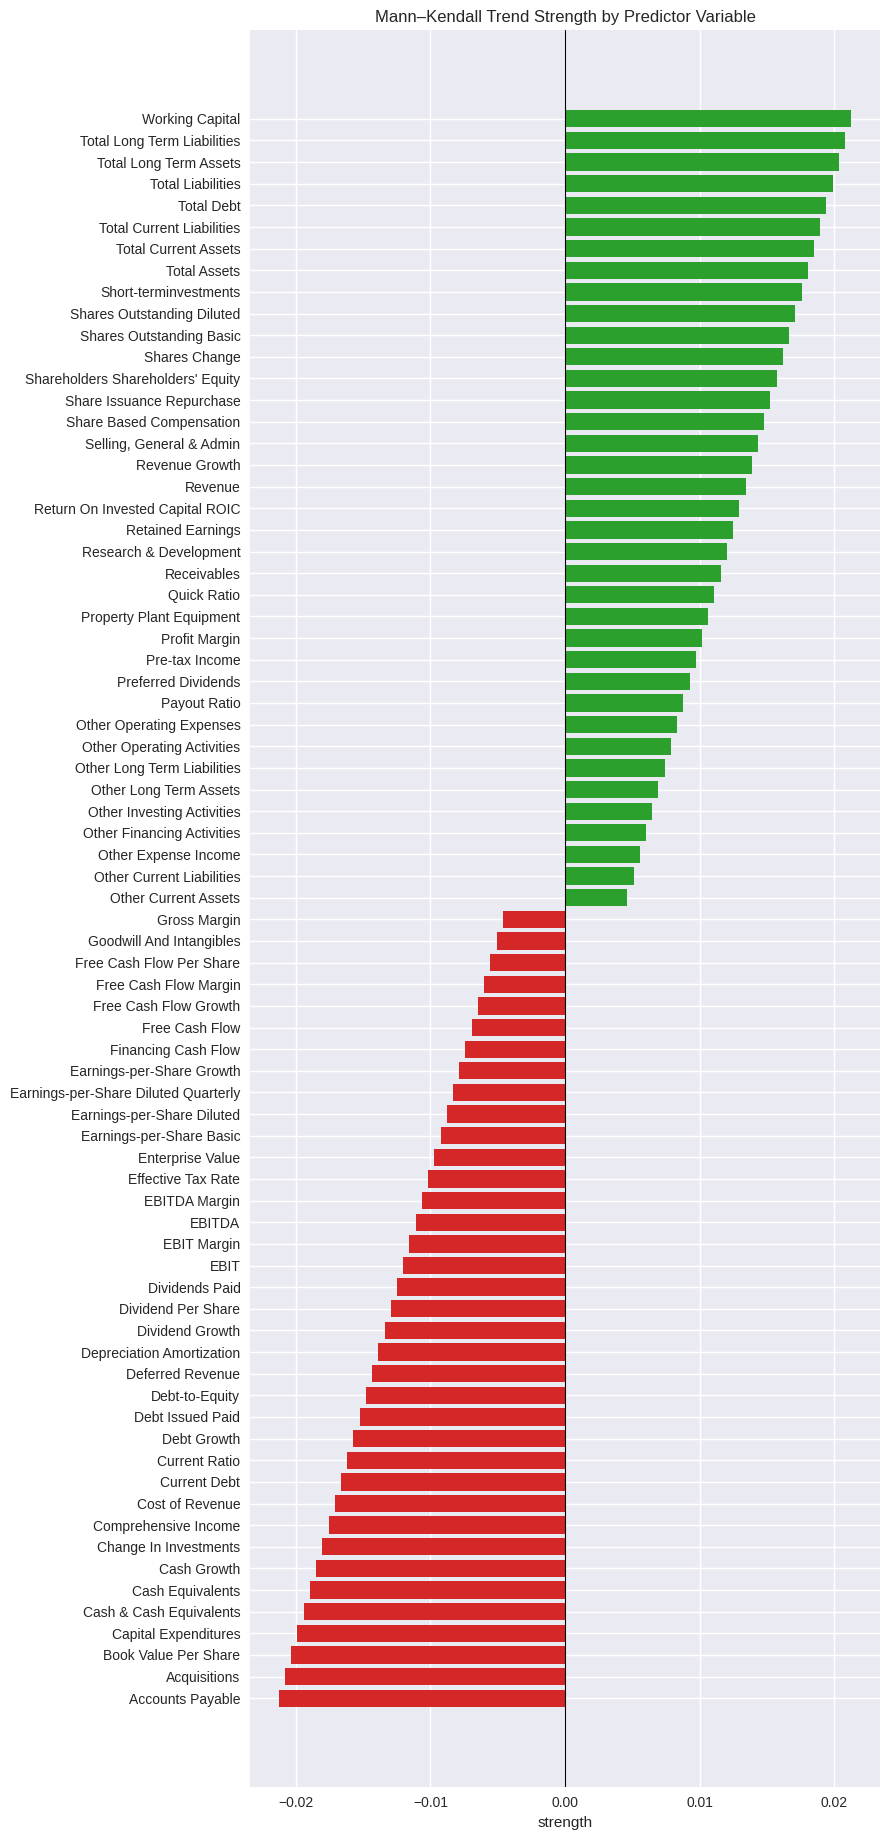

In [ ]:

# plot MK trends for each predictor variable
def plot_diverging_tau(mk_results_np_df, title="Mann–Kendall Trend Strength by Predictor Variable",
                       save_path=None, max_label_width=40):
    """
    Create a diverging horizontal bar chart of Kendall's tau by predictor variable.

    Parameters
    ----------
    mk_results_np_df : pandas.DataFrame
        Must contain columns: 'Predictor Variable', 'Trend', 'Strength (tau)'.
        'Trend' values should indicate direction (e.g., 'increasing' or 'decreasing').
    title : str
        Chart title.
    save_path : str or Path, optional
        If provided, saves the figure to this path.
    max_label_width : int
        Max characters for y-axis labels before truncating with an ellipsis.
    """

    # expected columns
    required_cols = ['proper_name', 'trends', 'strength']
    missing = [c for c in required_cols if c not in mk_results_np_df.columns]
    if missing:
        raise ValueError(f"Dataframe missing required columns: {missing}")

    # data prep
    df = mk_results_np_df.copy()
    # normalize/standardize direction labels
    df['Direction'] = df['trends'].str.strip().str.lower().map({
        'increasing': 'Increasing',
        'decreasing': 'Decreasing'
    }).fillna(df['trends'])

    # ensure tau is numeric
    df['strength'] = pd.to_numeric(df['strength'], errors='coerce')
    # sort by tau so negative values stack to the bottom (more intuitive)
    df_sorted = df.sort_values('strength', ascending=True).reset_index(drop=True)

    # Color mapping: Increasing = green; Decreasing = red; otherwise gray
    color_map = {
        'Increasing': '#2ca02c',  # green
        'Decreasing': '#d62728'   # red
    }
    colors = df_sorted['Direction'].map(color_map).fillna('#7f7f7f')

    # Plot
    # dynamic height
    height_inches = max(6, 0.25 * len(df_sorted))
    plt.figure(figsize=(9, height_inches))

    y_pos = np.arange(len(df_sorted))
    plt.barh(y_pos, df_sorted['strength'], color=colors)

    # vertical line at 0 to separate directions
    plt.axvline(0, color='black', linewidth=0.8)

    # shortened labels to keep chart readable
    y_labels = [shorten(str(x), width=max_label_width, placeholder='…')
                for x in df_sorted['proper_name']]
    plt.yticks(y_pos, y_labels)

    plt.xlabel('strength')
    plt.title(title)

    # Improve layout
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

# save visual
plot_diverging_tau(mk_results_np_df, save_path="/content/drive/MyDrive/data/01_diverging_tau_by_variable.jpeg")


In [ ]:
mk_results_np_df.head()

features  trend_detected  slopes      trends         pvals  \
0              gross_margin            True     0.0  decreasing  1.805308e-04   
1  goodwill_and_intangibles            True     0.0  decreasing  3.800380e-05   
2  free_cash_flow_per_share            True     0.0  decreasing  6.997156e-06   
3     free_cash_flow_margin            True     0.0  decreasing  1.125864e-06   
4     free_cash_flow_growth            True     0.0  decreasing  1.582089e-07   

   strength  significant                  name_one               proper_name  
0 -0.004625         True              gross_margin              Gross Margin  
1 -0.005088         True  goodwill_and_intangibles  Goodwill And Intangibles  
2 -0.005550         True  free_cash_flow_per_share  Free Cash Flow Per Share  
3 -0.006013         True     free_cash_flow_margin     Free Cash Flow Margin  
4 -0.006475         True     free_cash_flow_growth     Free Cash Flow Growth

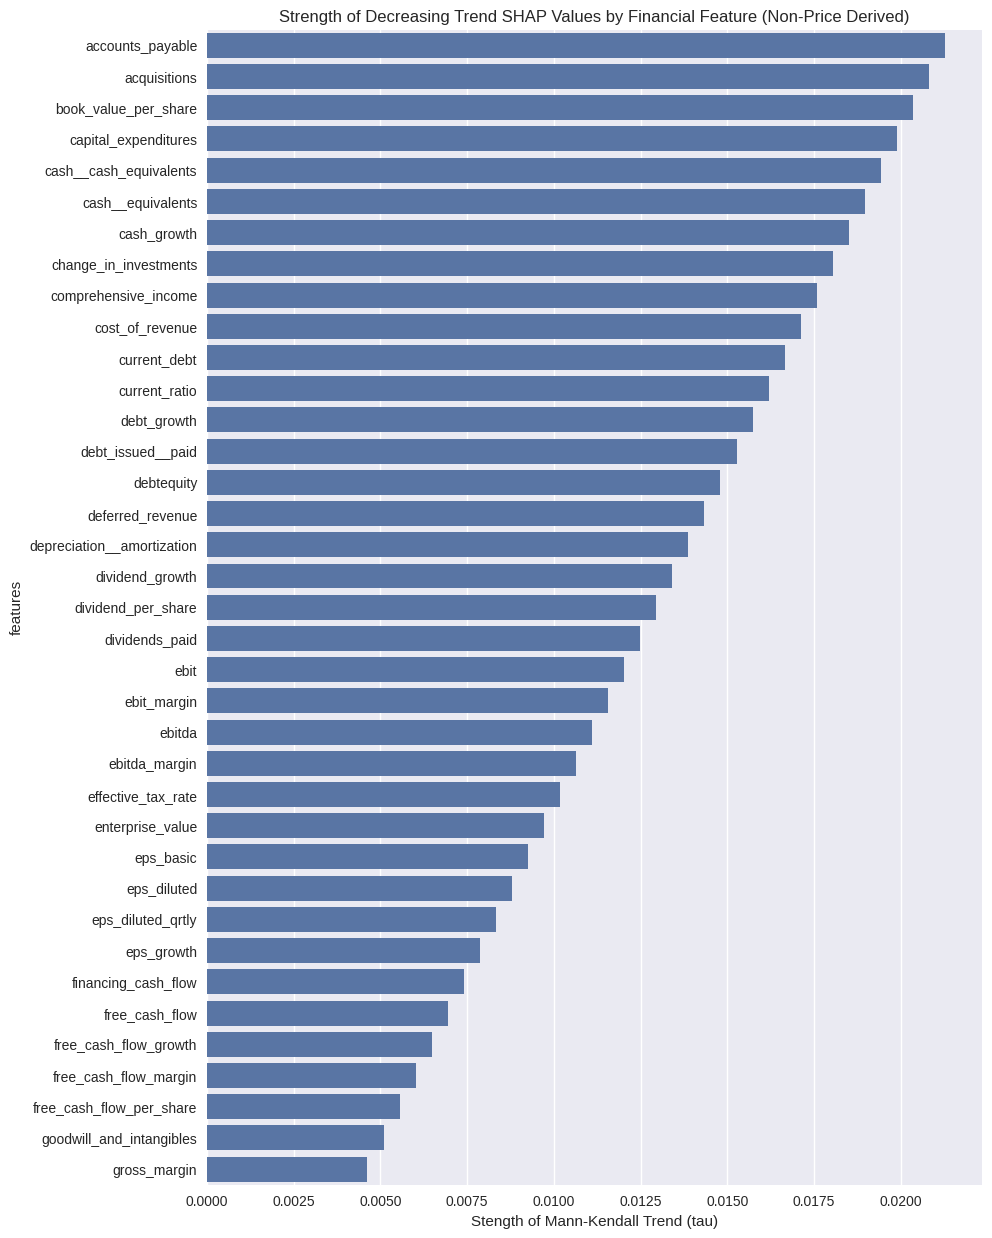

In [ ]:
# Visualize Mann-Kendall strength for those financial features with Decreasing Importance
# take absolute value of Mann-Kendall strength for visualization purposes
# This is only for decreasing trends
mk_decr_np_df_viz = mk_decr_np_df.copy()
mk_decr_np_df_viz['strength'] = mk_decr_np_df_viz['strength'].abs()
mk_decr_np_df_viz = mk_decr_np_df_viz.sort_values(by='strength', ascending=False)

plt.figure(figsize=(10,15))
sns.barplot(data=mk_decr_np_df_viz.sort_values(by='strength', ascending=False),
            y='features',
            x='strength'
            )
plt.title('Strength of Decreasing Trend SHAP Values by Financial Feature (Non-Price Derived)')
plt.xlabel('Stength of Mann-Kendall Trend (tau)')
plt.savefig('/content/drive/MyDrive/data/tau_decreasing_np_features.jpeg')
plt.show()

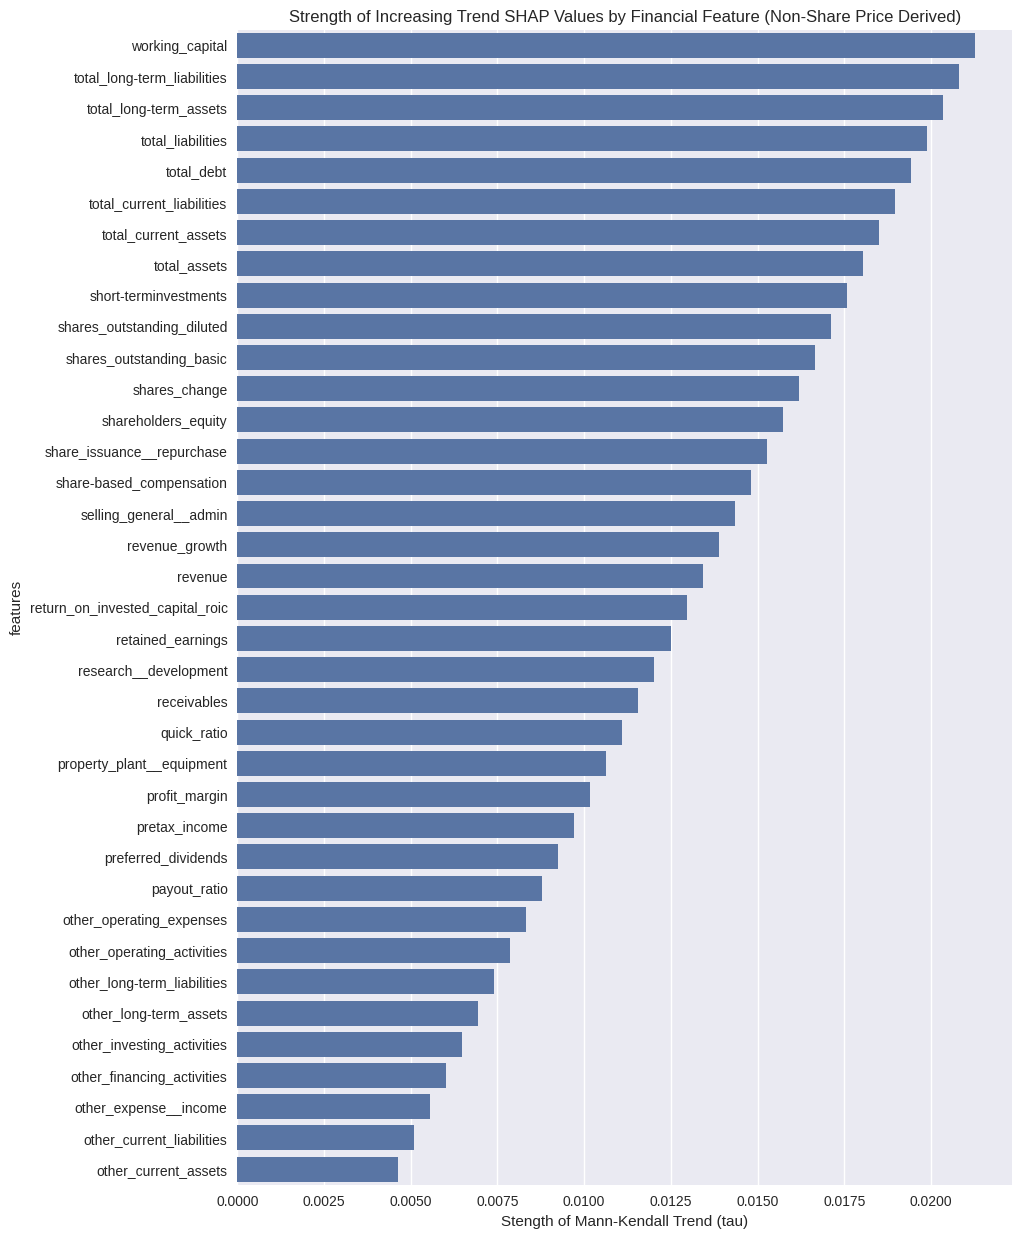

In [ ]:
# Visualize Mann-Kendall strength for those financial features with Increasing Importance
# financial features exclude any variables derived from the share price
mk_incr_np_df_viz = mk_incr_np_df.copy()

plt.figure(figsize=(10,15))
sns.barplot(data=mk_incr_np_df_viz.sort_values(by='strength', ascending=False),
            y='features',
            x='strength'
            )
plt.title('Strength of Increasing Trend SHAP Values by Financial Feature (Non-Share Price Derived)')
plt.xlabel('Stength of Mann-Kendall Trend (tau)')
plt.savefig('/content/drive/MyDrive/data/tau_increasing_np_features.jpeg')
plt.show()

##### Visualize Top 10 Mean and Standard Deviation SHAP for Features not Derived from Price

In [ ]:
# calculate mean and standard deviation SHAP values for each feature
# mean SHAP values present features with highest SHAP values over the study period
shap_np_mean_by_features = (shap_no_price_vars_df.groupby(['feature'], as_index=False)
                                              .agg(shap_feat_mean=('shap_val_mean', np.mean))
                                              .reset_index()
                        )
# standard deviation SHAP values present features with highest SHAP values fluctuation over the study period
shap_np_std_by_features = (shap_no_price_vars_df.groupby(['feature'], as_index=False)
                                                .agg(shap_feat_std=('shap_val_mean', np.std))
                                                .reset_index()
                        )

# drop index columns
shap_np_mean_by_features = shap_np_mean_by_features.drop(columns=['index'])
shap_np_std_by_features = shap_np_std_by_features.drop(columns=['index'])


# plot top features based off highest absolute shap values
top_n = 10
top_mean_shap_np_feat_df = shap_np_mean_by_features.nlargest(top_n, 'shap_feat_mean')
top_std_shap_np_feat_df = shap_np_std_by_features.nlargest(top_n, 'shap_feat_std')

# Collect feature names with highest mean and standard deviation
top_mean_shap_np_features = top_mean_shap_np_feat_df.feature.unique().tolist()
top_std_shap_np_features = top_std_shap_np_feat_df.feature.unique().tolist()



/tmp/ipython-input-126937370.py:4: FutureWarning: The provided callable <function mean at 0x7b8a2bfd3880> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(shap_feat_mean=('shap_val_mean', np.mean))
/tmp/ipython-input-126937370.py:9: FutureWarning: The provided callable <function std at 0x7b8a2bfd39c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .agg(shap_feat_std=('shap_val_mean', np.std))


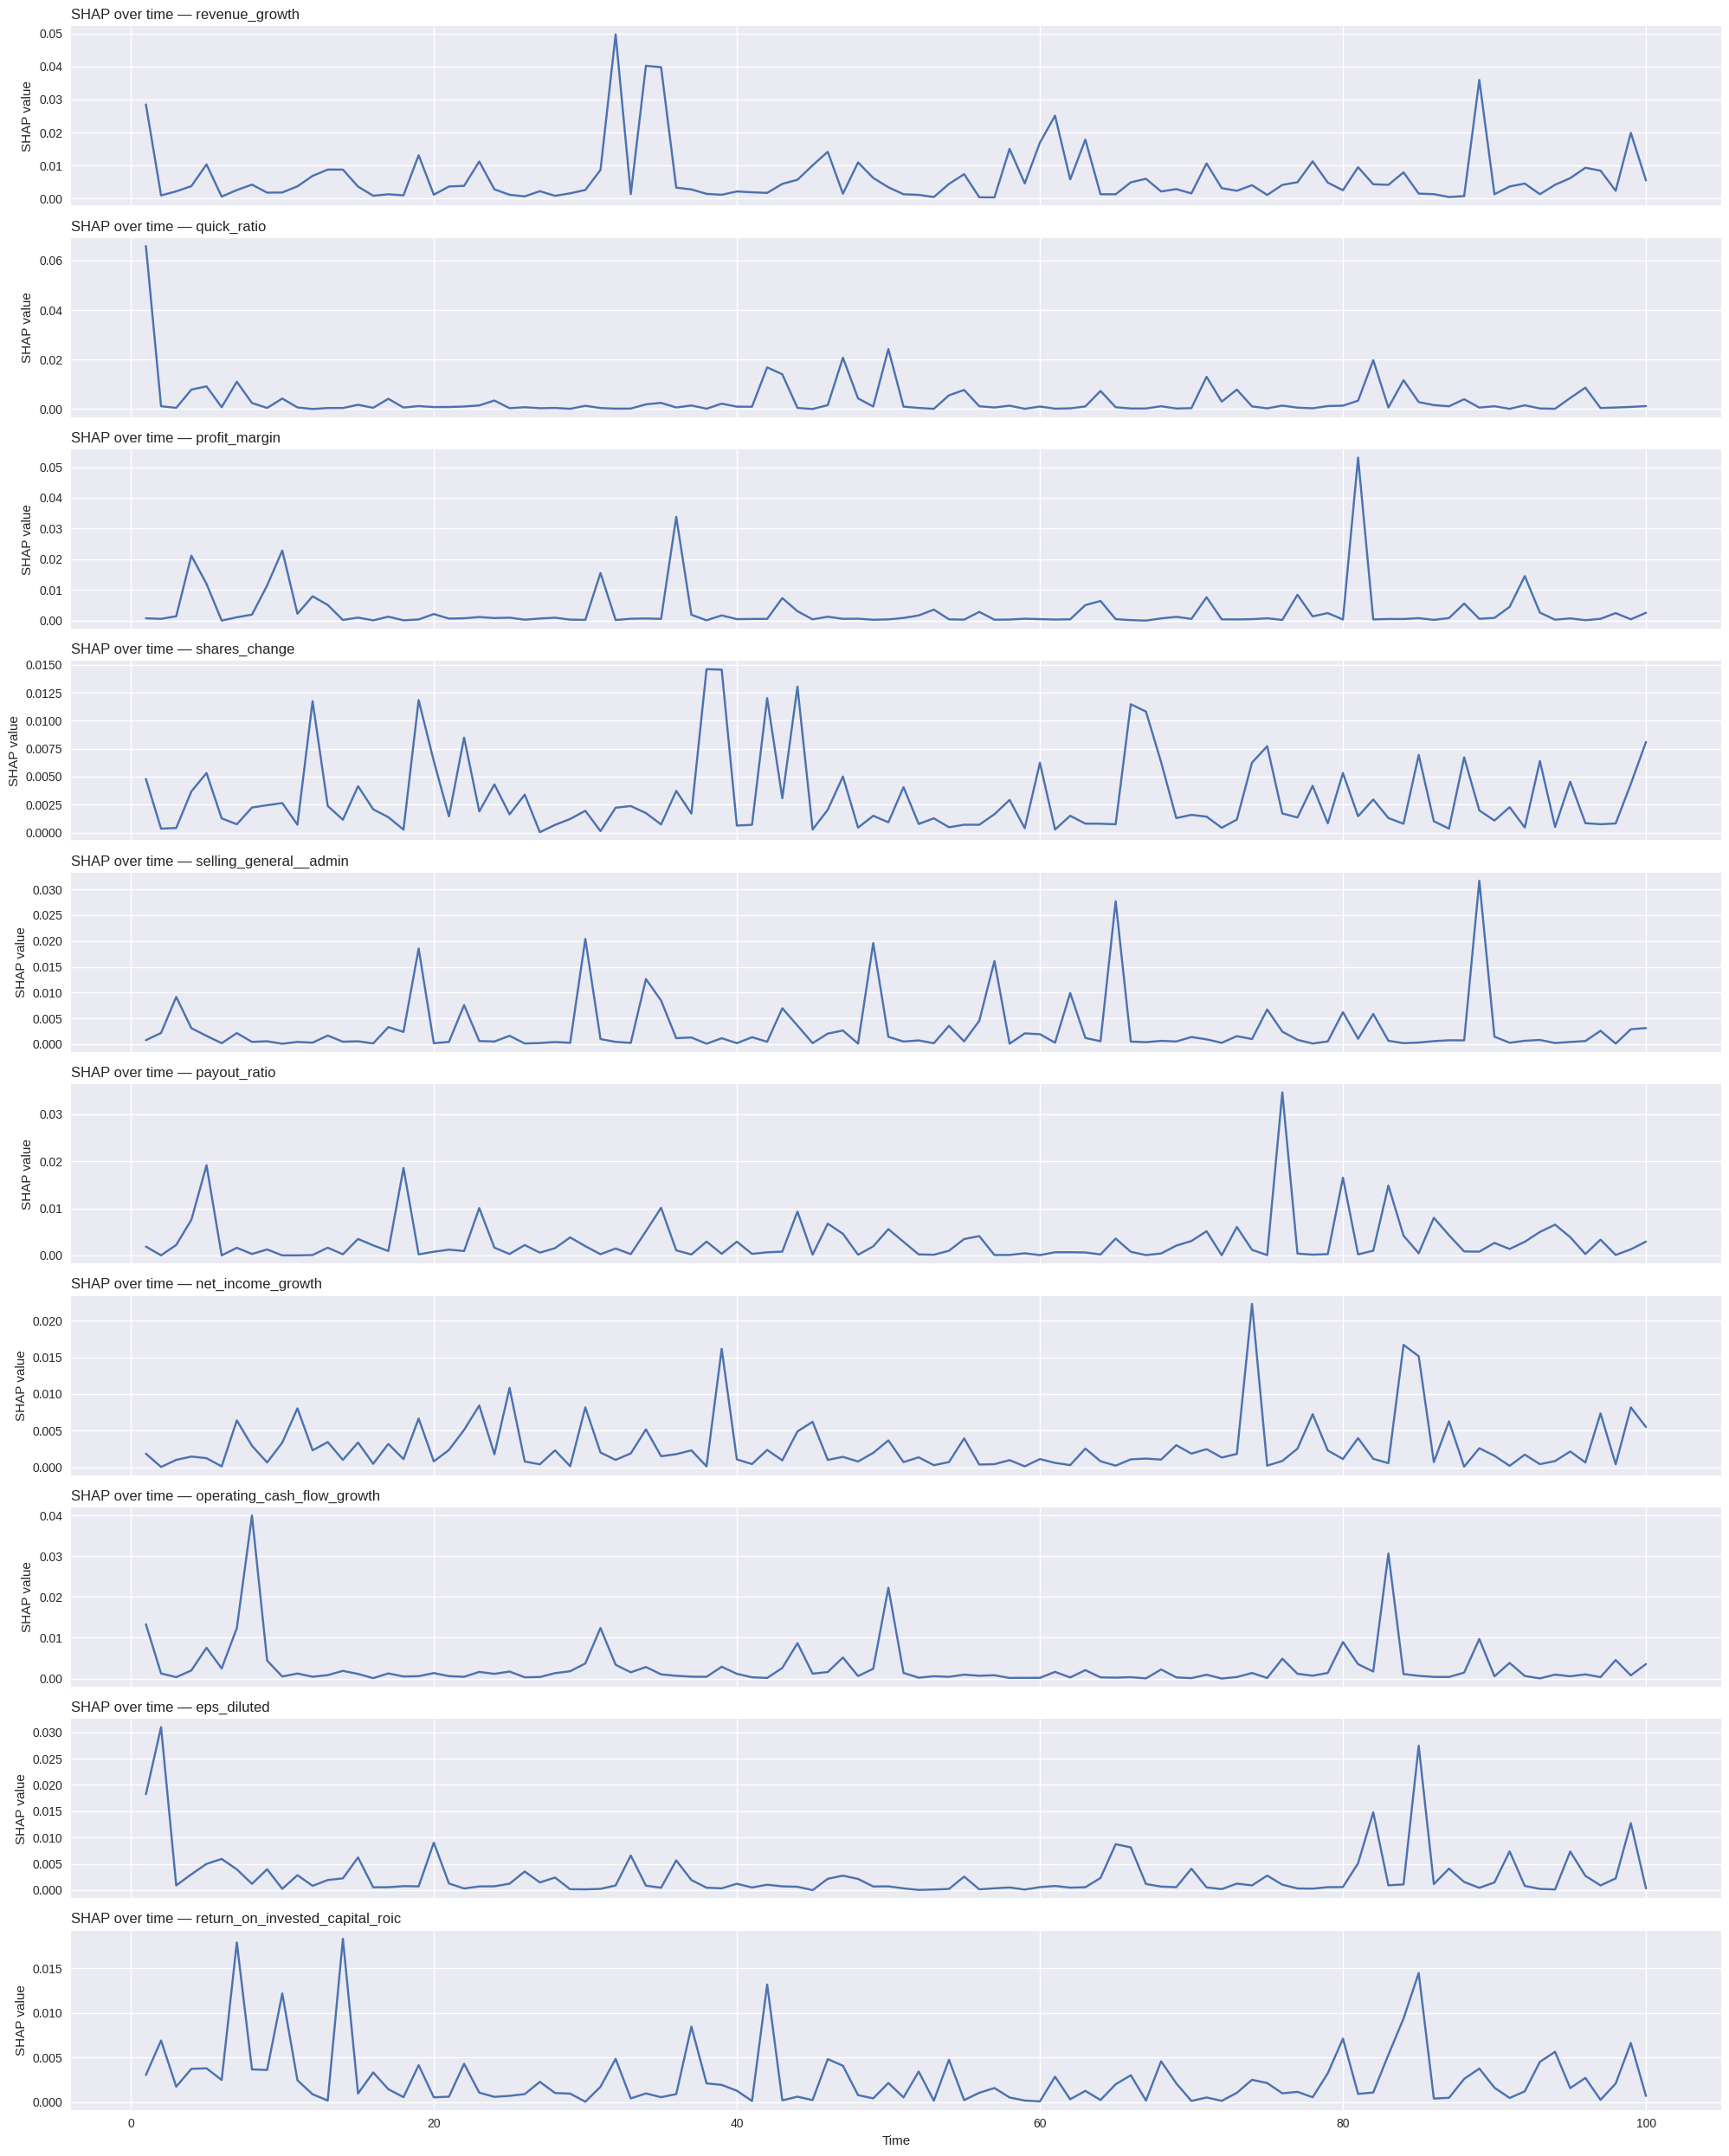

In [ ]:
# Visualize each line chart for the features with the top 10 highest SHAP means
# These are based on the features that exclude those features derived from the share price.
fig, axes = plt.subplots(nrows=top_n, ncols=1, figsize=(20, 2.5*top_n), sharex=True)

for i, feature in enumerate(top_mean_shap_np_features):
    ax = axes[i]
    data = shap_no_price_vars_df[shap_no_price_vars_df['feature'] == feature]

    sns.lineplot(
        data=data,
        x='time_series',
        y='shap_val_mean',
        ax=ax
    )

    ax.set_title(f"SHAP over time — {feature}", loc='left')
    ax.set_ylabel("SHAP value")
    ax.legend_.remove() if ax.get_legend() else None
    sns.despine(ax=ax)

axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/data/shap_mean_by_np_features.jpeg')
plt.show()


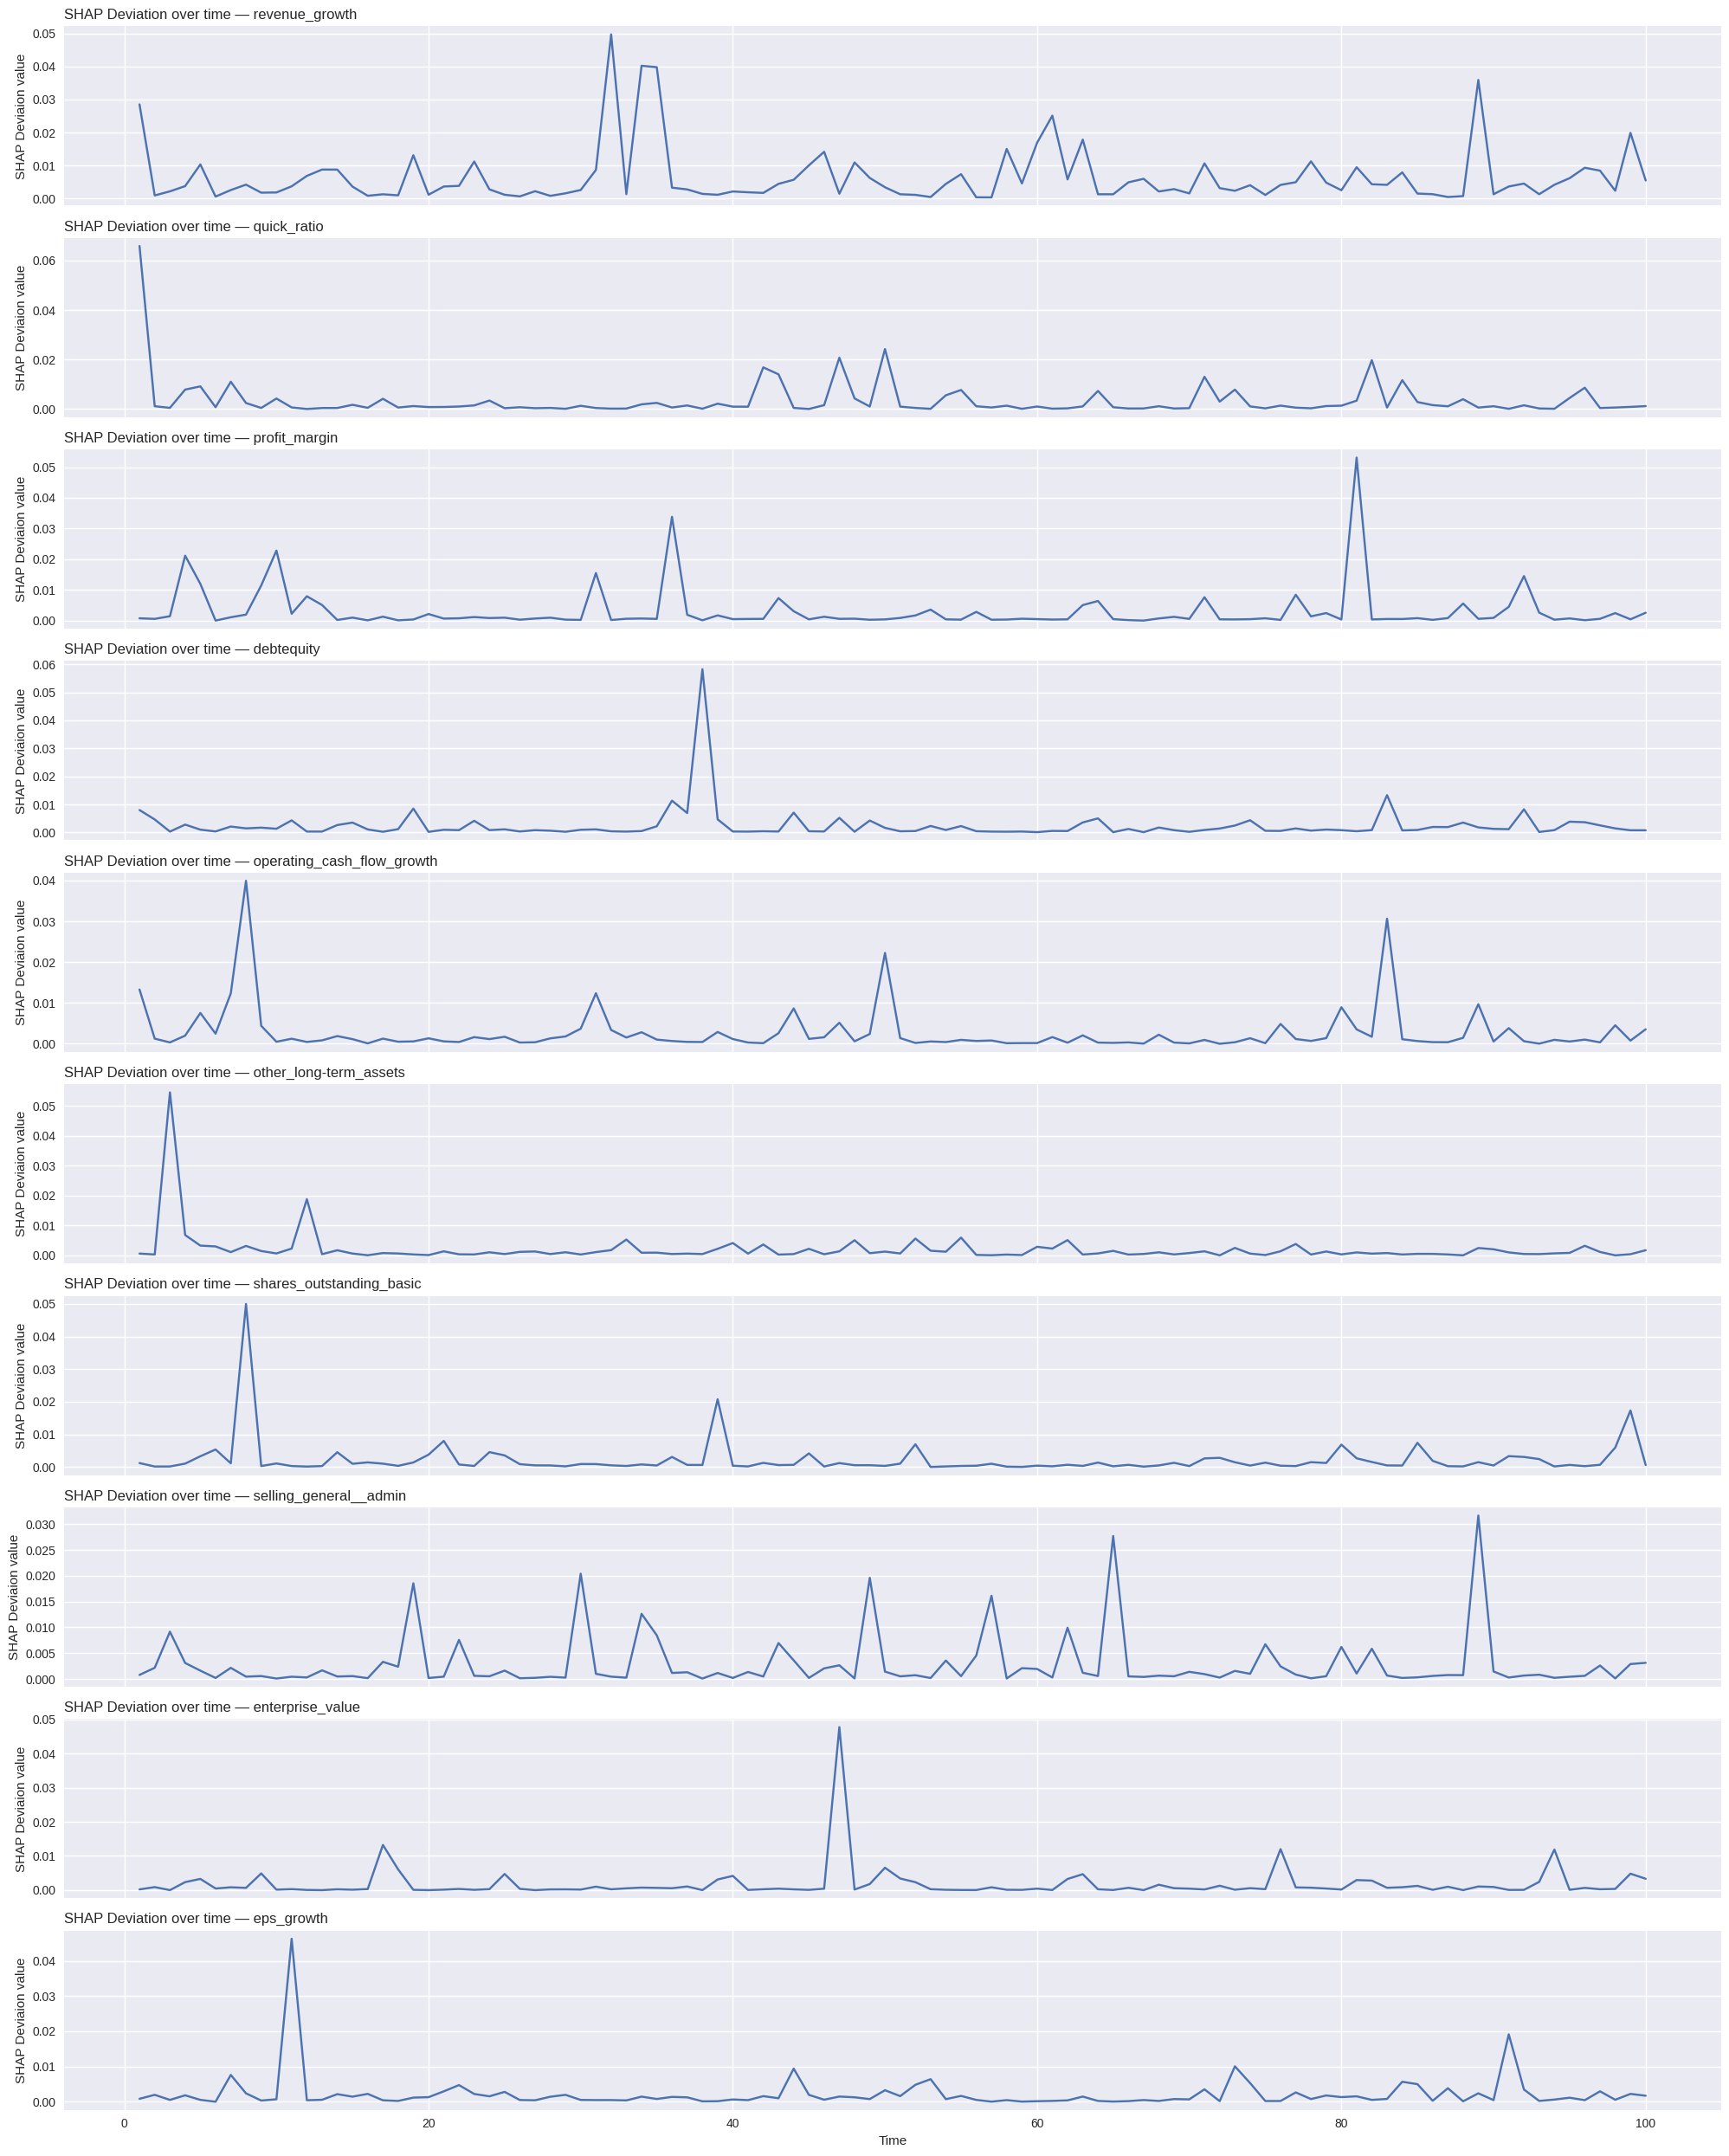

In [ ]:

# Visualize each line chart for the features with the top 10 highest SHAP standard deviations
# These are based on the features that exclude those features derived from the share price.
# The below presents the 10 features with the highest standard deviations over the time period.
# Purpose here is to identify where high volatility occurs

fig, axes = plt.subplots(nrows=top_n, ncols=1, figsize=(20, 2.5*top_n), sharex=True)

for i, feature in enumerate(top_std_shap_np_features):
    ax = axes[i]
    data = shap_no_price_vars_df[shap_no_price_vars_df['feature'] == feature]

    sns.lineplot(
        data=data,
        x='time_series',
        y='shap_val_mean',
        ax=ax
    )

    ax.set_title(f"SHAP Deviation over time — {feature}", loc='left')
    ax.set_ylabel("SHAP Deviaion value")
    ax.legend_.remove() if ax.get_legend() else None
    sns.despine(ax=ax)


axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/data/shap_std_by_np_features.jpeg')
plt.show()


##### Distribution of SHAP values for variables not dervied from price

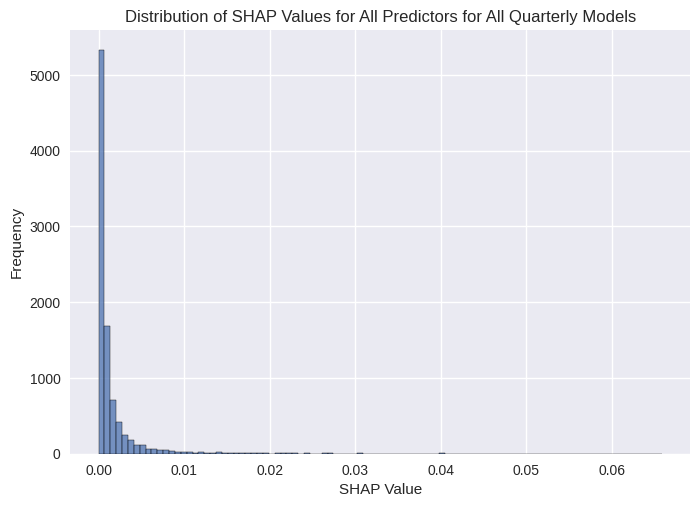

In [ ]:
shap_no_price_vars_df.head()
sns.histplot(data=shap_no_price_vars_df, x= 'shap_val_mean', bins=int(np.sqrt(len(shap_no_price_vars_df))))
plt.title('Distribution of SHAP Values for All Predictors for All Quarterly Models')
plt.xlabel('SHAP Value')
plt.ylabel('Frequency')
plt.savefig('/content/drive/MyDrive/data/np_shap_dist_all_quarters.jpeg')
plt.show()

#### EXPERIMENT 3(a): TEST FOR CHANGEPOINTS

In [ ]:
all_shap_df.head()

index           feature  shap_val_mean  time_series
0        1  accounts_payable       0.000000          100
103      2  accounts_payable       0.002243           99
206      3  accounts_payable       0.000036           98
309      4  accounts_payable       0.000937           97
412      5  accounts_payable       0.000171           96

In [ ]:
# Detect changepoints using Pruned Exact Linear Time (PELT)

# sort shap values by feature and index
# index 1 is for most recent period i.e. Q4 2024 so index is sorted in descending order
all_shap_df = all_shap_df.sort_values(by=['feature', 'time_series'], ascending=[True, False])

# create dict to hold changepoints by each feature
detected_cps = {}
# penalty grid for grid search; this will run CP tests on different penalties to find changepoint
penalty_grid = [1, 5, 10, 20, 50]
n_points = len(all_shap_df)

# Detect change points with grid search (of varying penalty)
# Multiple penalty rates used to create more robust testing to identify changepoints
# once and if a changepoint is detected, loop moves to next feature
for feature in all_shap_df.feature.unique():
    series = all_shap_df[all_shap_df['feature'] == feature]['shap_val_mean'].values
    algo = rpt.Pelt(model="rbf").fit(series)

    best_cp = None
    for pen in penalty_grid:
        cps = algo.predict(pen=pen)
        # remove terminal index
        cps = [cp for cp in cps if cp < len(series)]
        if cps:
            # if any change points detected, take first changepoint
            best_cp = cps[0]
            # stop at first penalty that gives a CP
            break

    detected_cps[feature] = best_cp

# Compute p-values for detected Changepoints; determines if Changepoints are significant
# Uses 2 sample t-test mean comparison of series before and after changepoint
p_values = []
for feature in all_shap_df.feature.unique():
    cp = detected_cps[feature]
    series_for_pval = all_shap_df[all_shap_df['feature'] == feature]['shap_val_mean'].values
    # mark NaN for features with no changepoints or where changepoint is in terminal index
    if cp is None or cp >= len(series_for_pval):
        p_values.append(np.nan)
        continue
    before = series_for_pval[:cp]
    after = series_for_pval[cp:]

    # Ensure there are enough samples in both 'before' and 'after' for ttest_ind
    if len(before) > 1 and len(after) > 1:
        stat, p_val = ttest_ind(before, after, equal_var=False)
        p_values.append(p_val)
    else:
        p_values.append(np.nan)

# Calculate Bonferroni correction alpha
predictors = all_shap_df.feature.unique()
n = len(predictors)
alpha = 0.05
adjusted_alpha = alpha / n
significance = [p < adjusted_alpha if not np.isnan(p) else False for p in p_values]

summary_df = pd.DataFrame({
    "Feature": predictors,
    "Detected_CP": [detected_cps[f] for f in predictors],
    "p_value": p_values,
    "Significant": significance,
    "AdjustedAlpha": adjusted_alpha
})




In [ ]:
# All features show no significant changepoints in the time-series over the study time period
summary_df['Significant'].value_counts()

Significant
False    98
True      5
Name: count, dtype: int64

##### Save Changepoint HT Results for All Features

In [ ]:
summary_df.to_csv('/content/drive/MyDrive/data/changepoint_summary_all_features.csv', index=False)

#### EXPERIMENT 3(b): TEST FOR CHANGEPOINTS FEATURES NOT DERIVED FROM PRICE

In [ ]:
# Detect changepoints using Pruned Exact Linear Time (PELT)
# These features exclude those features derived from the share price

# sort shap values by feature and index
# index 1 is for most recent period i.e. Q4 2024 so index is sorted in descending order
shap_no_price_vars_df = shap_no_price_vars_df.sort_values(by=['feature', 'time_series'], ascending=[True, False])

# create dict to hold changepoints by each feature
detected_cps = {}
# penalty grid for grid search; this will run CP tests on different penalties to find changepoint
penalty_grid = [1, 5, 10, 20, 50]
n_points = len(shap_no_price_vars_df)

# Detect change points with grid search (of varying penalty)
# Multiple penalty rates used to create more robust testing to identify changepoints
# once and if a changepoint is detected, loop moves to next feature
for feature in shap_no_price_vars_df.feature.unique():
    series = shap_no_price_vars_df[shap_no_price_vars_df['feature'] == feature]['shap_val_mean'].values
    algo = rpt.Pelt(model="rbf").fit(series)

    best_cp = None
    for pen in penalty_grid:
        cps = algo.predict(pen=pen)
        # remove terminal index
        cps = [cp for cp in cps if cp < len(series)]
        if cps:
            # if any change points detected, take first changepoint
            best_cp = cps[0]
            # stop at first penalty that gives a CP
            break

    detected_cps[feature] = best_cp

# Compute p-values for detected Changepoints; determines if Changepoints are significant
# Uses 2 sample t-test mean comparison of series before and after changepoint
p_values = []
for feature in shap_no_price_vars_df.feature.unique():
    cp = detected_cps[feature]
    series_for_pval = shap_no_price_vars_df[shap_no_price_vars_df['feature'] == feature]['shap_val_mean'].values
    # mark NaN for features with no changepoints or where changepoint is in terminal index
    if cp is None or cp >= len(series_for_pval):
        p_values.append(np.nan)
        continue
    before = series_for_pval[:cp]
    after = series_for_pval[cp:]

    # Ensure there are enough samples in both 'before' and 'after' for ttest_ind
    if len(before) > 1 and len(after) > 1:
        stat, p_val = ttest_ind(before, after, equal_var=False)
        p_values.append(p_val)
    else:
        p_values.append(np.nan)

# Calculate Bonferroni correction alpha
predictors = shap_no_price_vars_df.feature.unique()
n = len(predictors)
alpha = 0.05
adjusted_alpha = alpha / n
significance = [p < adjusted_alpha if not np.isnan(p) else False for p in p_values]

summary_np_df = pd.DataFrame({
    "Feature": predictors,
    "Detected_CP": [detected_cps[f] for f in predictors],
    "p_value": p_values,
    "Significant": significance,
    "AdjustedAlpha": adjusted_alpha
})


In [ ]:
summary_np_df.Significant.value_counts()

Significant
False    92
True      1
Name: count, dtype: int64

In [ ]:
summary_np_df[summary_np_df['Significant']==True]

Feature  Detected_CP   p_value  Significant  AdjustedAlpha
72  research__development          5.0  0.000291         True       0.000538

##### Save Changepoint HT Results using Features Not Dervied from Price

In [ ]:
summary_np_df.to_csv('/content/drive/MyDrive/data/changepoint_summary_np_features.csv', index=False)